In [1]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, jaccard_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the target size for resizing
target_size = (544, 544)

# Initialize lists to store the preprocessed images and labels
images_list = []
labels_list = []

# Define the paths to the images and labels directories
images_dir = "/Users/yashvats/Desktop/project/DATA/images"
labels_dir = "/Users/yashvats/Desktop/project/DATA/labels"

# Get the list of image and label files
image_files = os.listdir(images_dir)
label_files = os.listdir(labels_dir)

# Loop through the image and label files and preprocess them
for i in range(len(image_files)):
    # Load the image and label
    image_path = os.path.join(images_dir, image_files[i])
    label_path = os.path.join(labels_dir, label_files[i])
    image = Image.open(image_path)
    label = Image.open(label_path)
    
    # Resize the image and label
    image = image.resize(target_size)
    label = label.resize(target_size)
    
    # Normalize the image pixel values to [0, 1]
    image = np.array(image) / 255.0
    label = np.array(label)
    
    # Append the preprocessed image and label to the lists
    images_list.append(image)
    labels_list.append(label)

# Convert the lists to numpy arrays
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# One-hot encode the labels
labels_onehot = to_categorical(labels_array)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images_array, labels_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (608, 544, 544, 3) (608, 544, 544, 4)
Validation data shape: (130, 544, 544, 3) (130, 544, 544, 4)
Test data shape: (131, 544, 544, 3) (131, 544, 544, 4)


In [2]:

# Define the U-Net model
inputs = Input((None, None, 3))
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)

up3 = concatenate([UpSampling2D(size=(2, 2))(conv2), conv1], axis=3)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(up3)
conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)

conv4 = Conv2D(4, 1, activation='softmax')(conv3)

model = Model(inputs=[inputs], outputs=[conv4])



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and best model saving
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [3]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[EarlyStopping, ModelCheckpoint],
    verbose=1
)


Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.8602
Epoch 1: val_loss improved from inf to 0.31228, saving model to unet_model.h5
76/76 [==============================] - 431s 6s/step - loss: 0.4717 - accuracy: 0.8602 - val_loss: 0.3123 - val_accuracy: 0.8754
Epoch 2/20


/Users/yashvats/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8689
Epoch 2: val_loss improved from 0.31228 to 0.29963, saving model to unet_model.h5
76/76 [==============================] - 434s 6s/step - loss: 0.3186 - accuracy: 0.8689 - val_loss: 0.2996 - val_accuracy: 0.8767
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8718
Epoch 3: val_loss improved from 0.29963 to 0.29009, saving model to unet_model.h5
76/76 [==============================] - 424s 6s/step - loss: 0.3096 - accuracy: 0.8718 - val_loss: 0.2901 - val_accuracy: 0.8826
Epoch 4/20
76/76 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8789
Epoch 4: val_loss did not improve from 0.29009
76/76 [==============================] - 417s 5s/step - loss: 0.3003 - accuracy: 0.8789 - val_loss: 0.2939 - val_accuracy: 0.8814
Epoch 5/20
76/76 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8830
Epoch 5: val_loss improved from 0.

In [3]:
# Load the model
loaded_model = load_model('model.h5')

print('Model loaded successfully.')

Model loaded successfully.


In [6]:
# Evaluate the loaded model on the validation data
scores_val = loaded_model.evaluate(X_val, y_val, verbose=0)
print("Validation loss:", scores_val[0])
print("Validation accuracy:", scores_val[1])

# Evaluate the loaded model on the test data
scores_test = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", scores_test[0])
print("Test accuracy:", scores_test[1])


Validation loss: 0.2016659379005432
Validation accuracy: 0.9278495907783508
Test loss: 0.21116264164447784
Test accuracy: 0.923295795917511


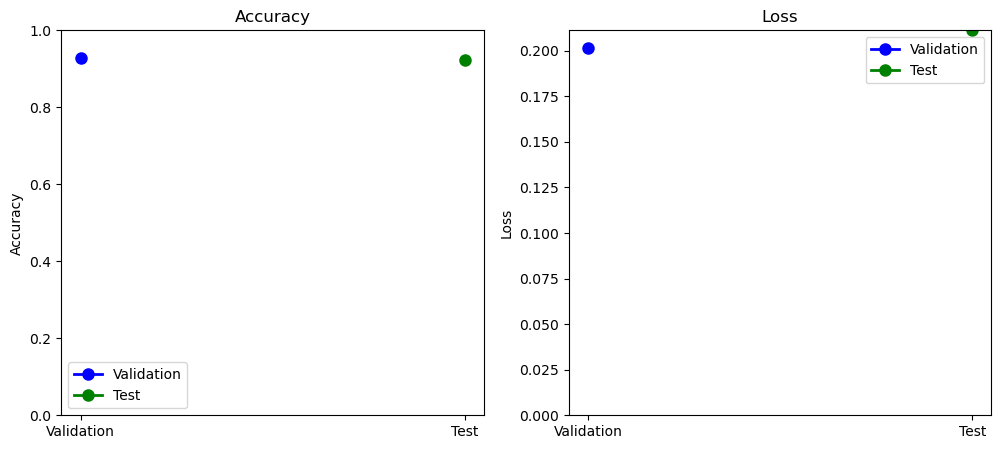

In [5]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [18]:


# Get the model predictions
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

# Flatten the ground truth labels and model predictions
y_true_flat = y_test.argmax(axis=-1).flatten()
y_pred_flat = predictions.flatten()

# Calculate and print the classification report
report = classification_report(y_true_flat, y_pred_flat, labels=[0, 1, 2, 3], 
                               target_names=['Background', 'Plaque', 'Lumen', 'Artifacts'])
print("Classification Report:")
print(report)

# Calculate and print the IoU for each class
iou_scores = jaccard_score(y_true_flat, y_pred_flat, average=None, labels=[0, 1, 2, 3])
for i, iou in enumerate(iou_scores):
    print(f"IoU Score for Class {i} ({['Background', 'Plaque', 'Lumen', 'Artifacts'][i]}): {iou:.4f}")


5/5 [==============================] - 24s 4s/step
Classification Report:
              precision    recall  f1-score   support

  Background       0.96      0.98      0.97  28248990
      Plaque       0.80      0.64      0.71   3455775
       Lumen       0.36      0.00      0.01    592057
   Artifacts       0.79      0.88      0.83   6470794

    accuracy                           0.92  38767616
   macro avg       0.73      0.63      0.63  38767616
weighted avg       0.91      0.92      0.91  38767616

IoU Score for Class 0 (Background): 0.9445
IoU Score for Class 1 (Plaque): 0.5558
IoU Score for Class 2 (Lumen): 0.0035
IoU Score for Class 3 (Artifacts): 0.7124


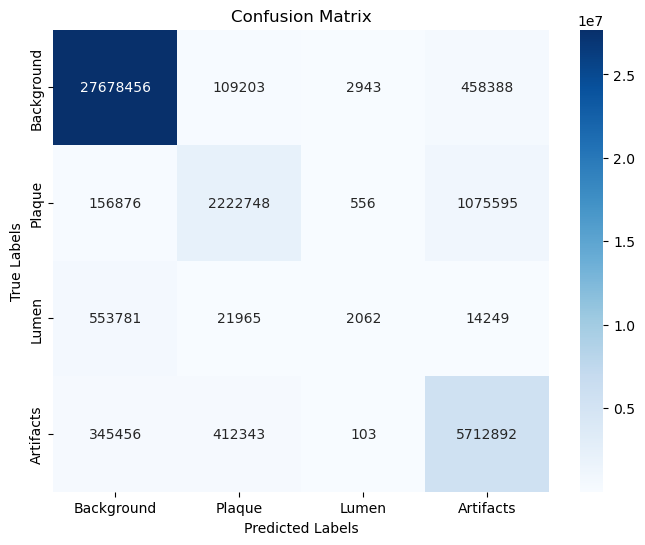

In [19]:


# Create the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Plaque', 'Lumen', 'Artifacts'], 
            yticklabels=['Background', 'Plaque', 'Lumen', 'Artifacts'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


5/5 [==============================] - 20s 4s/step


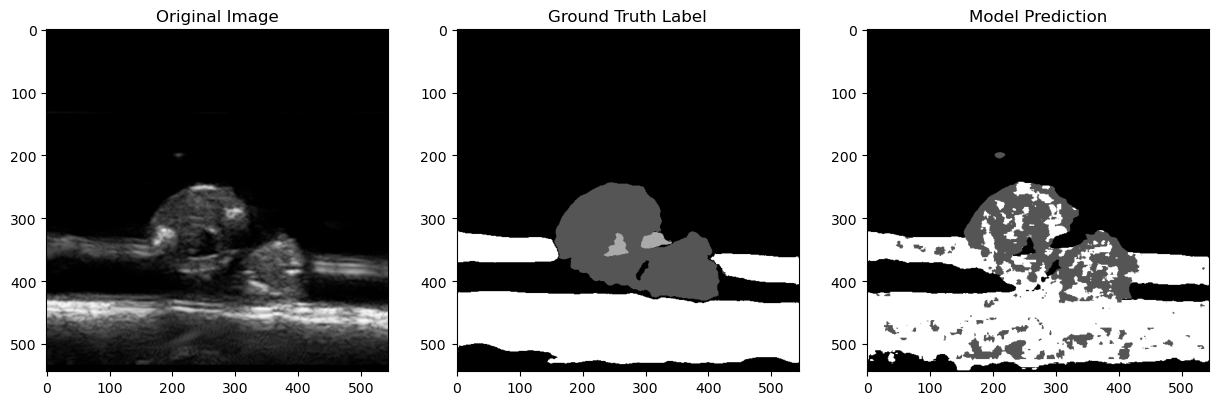

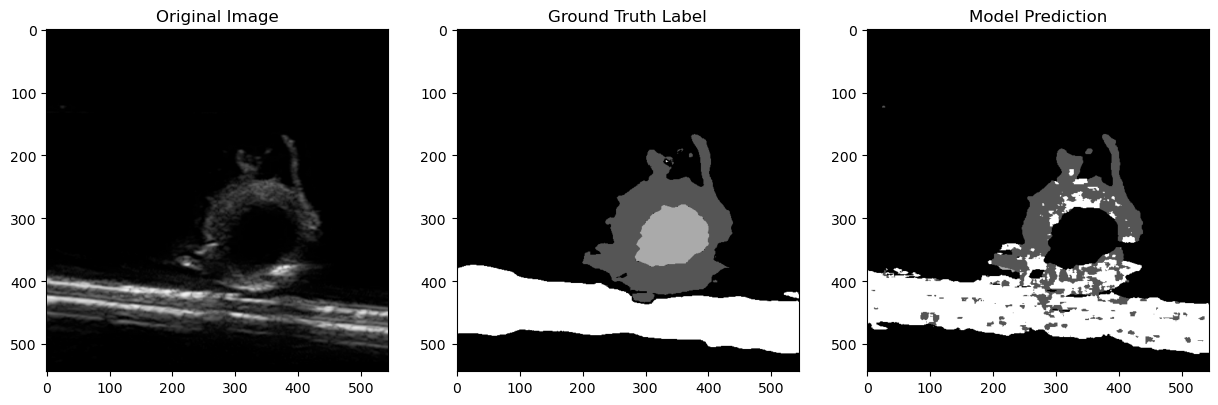

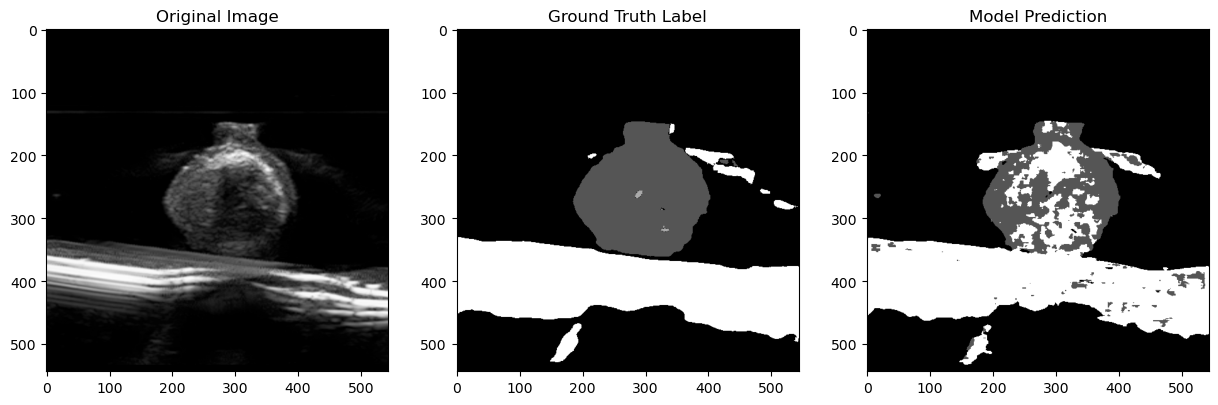

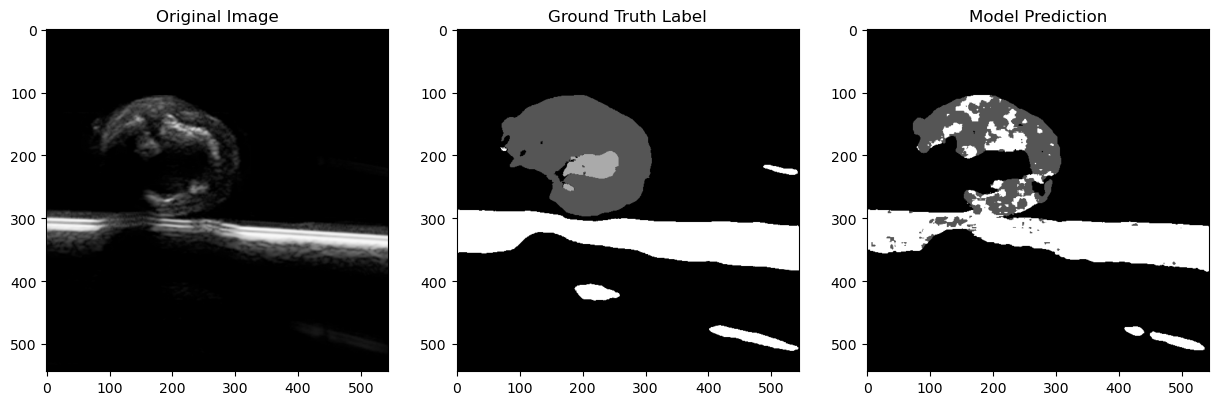

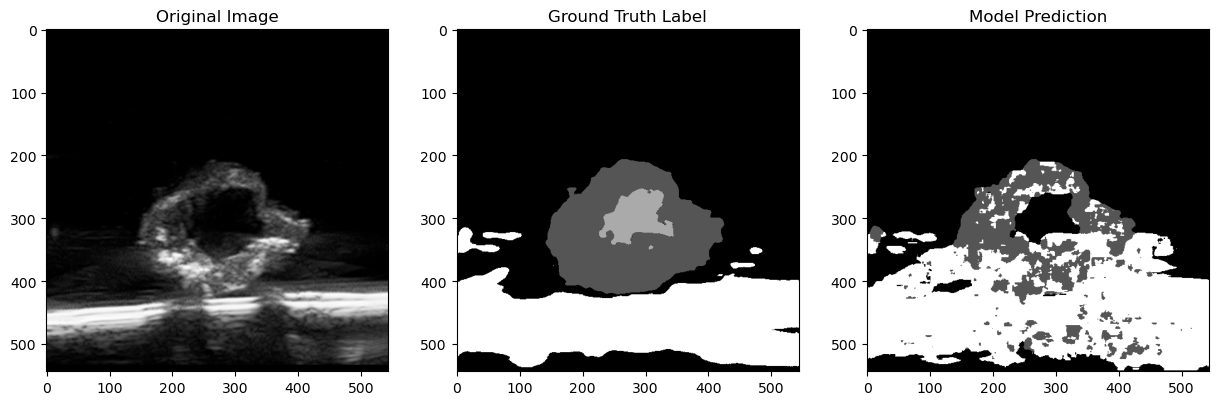

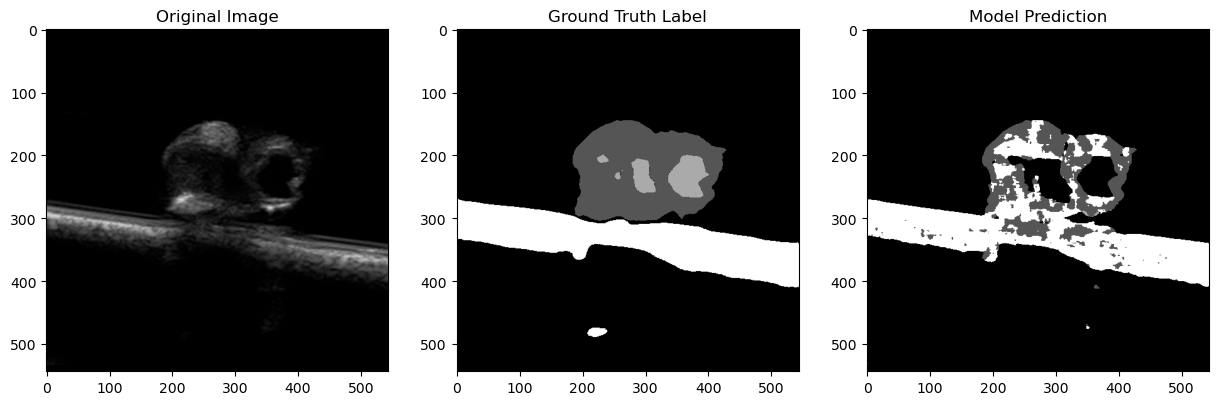

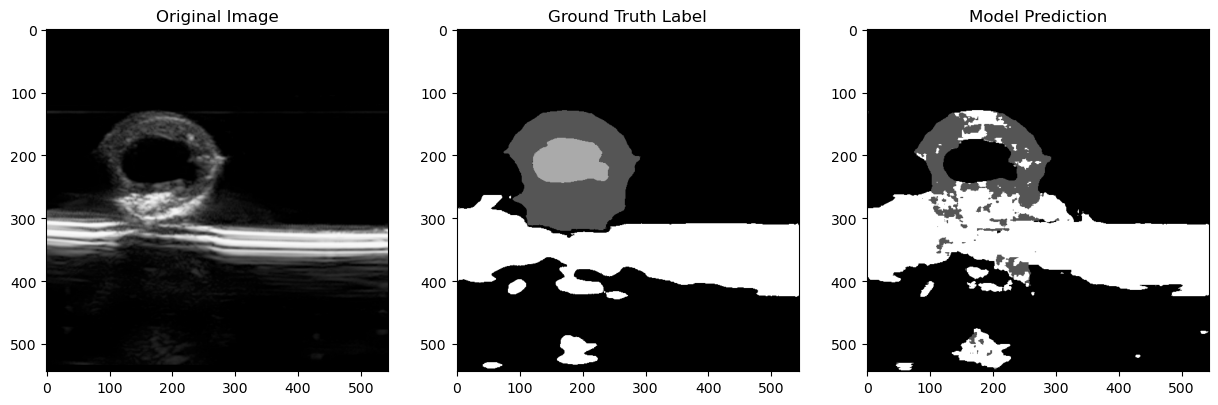

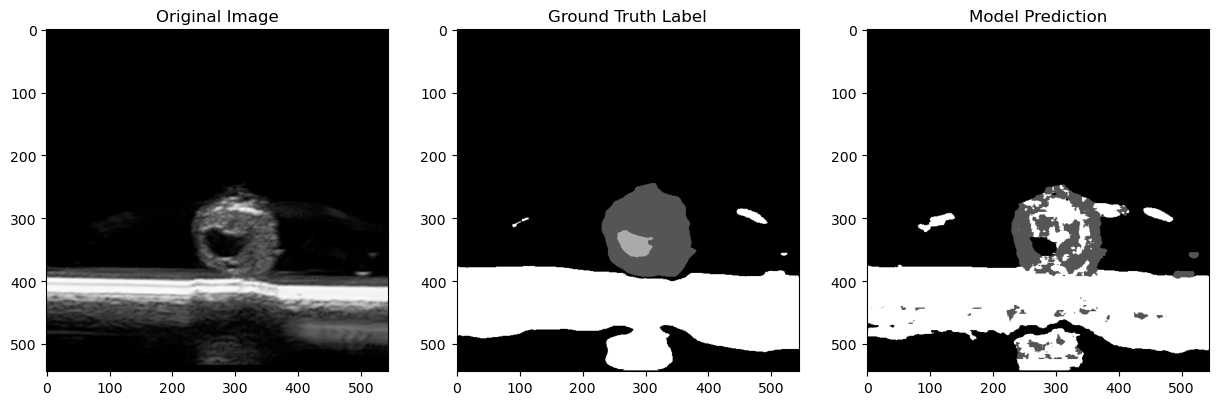

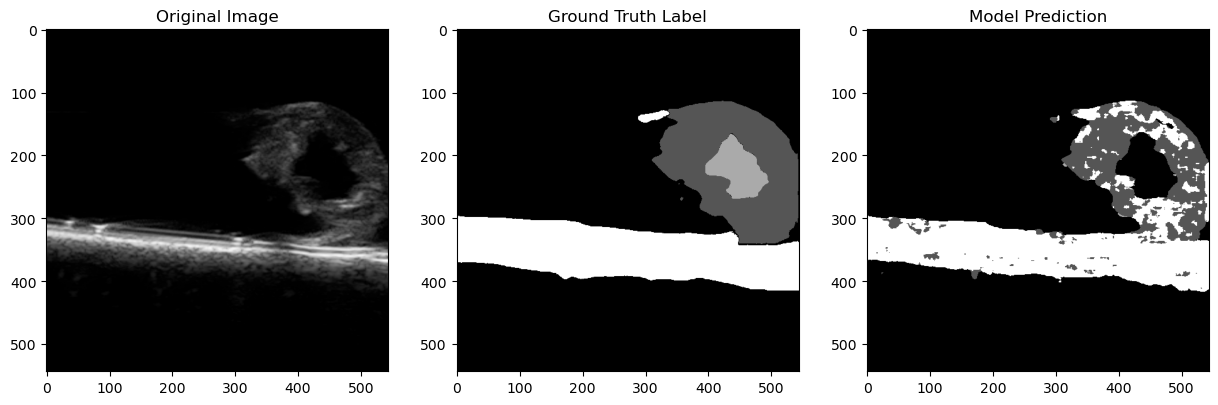

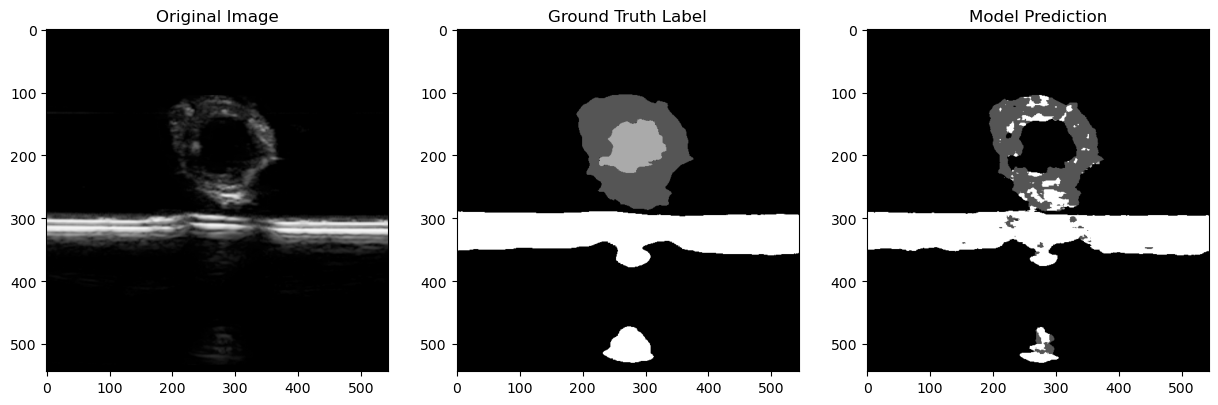

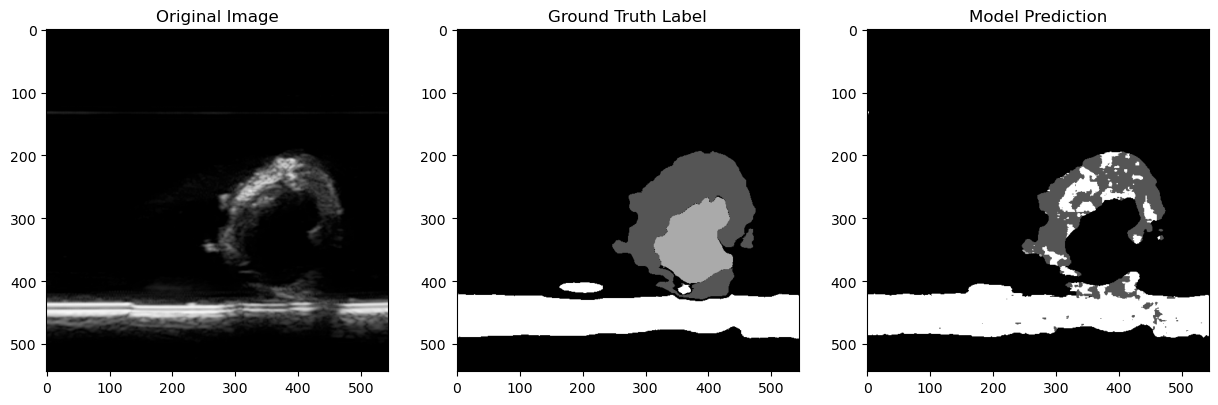

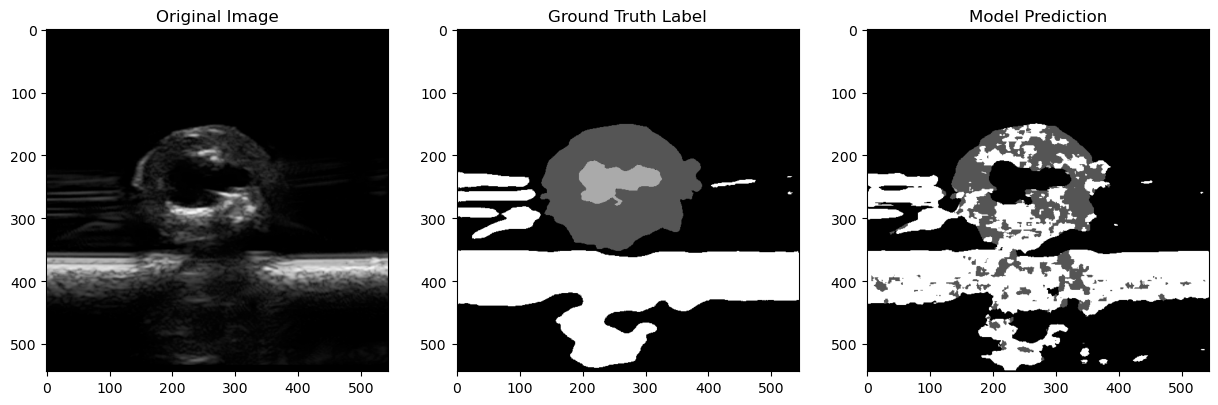

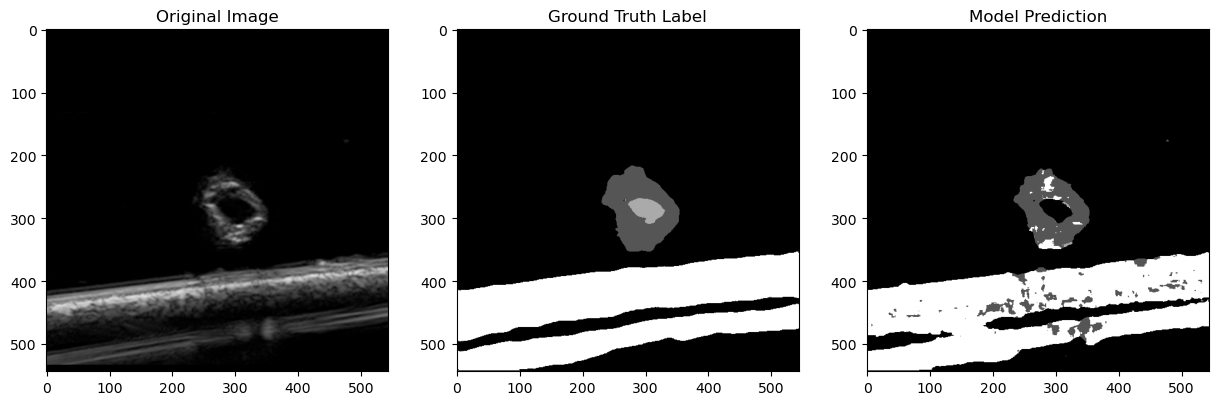

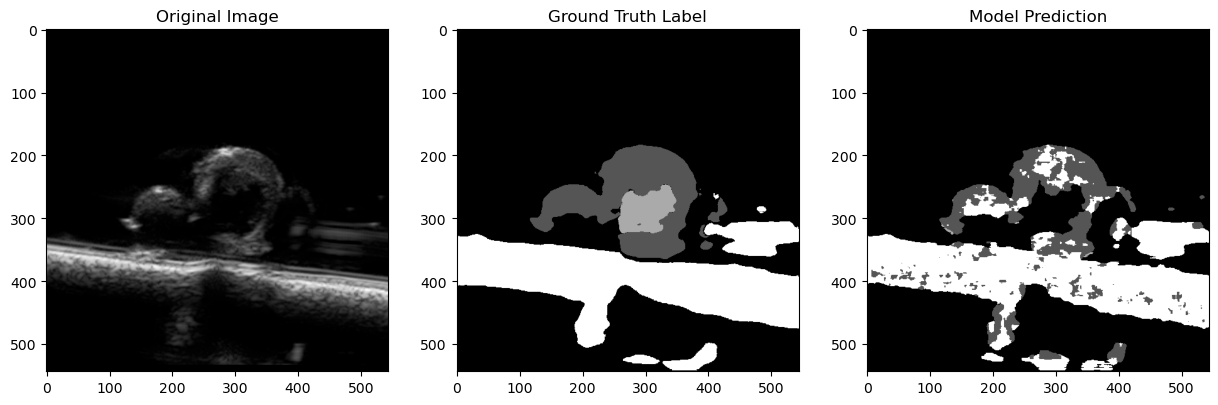

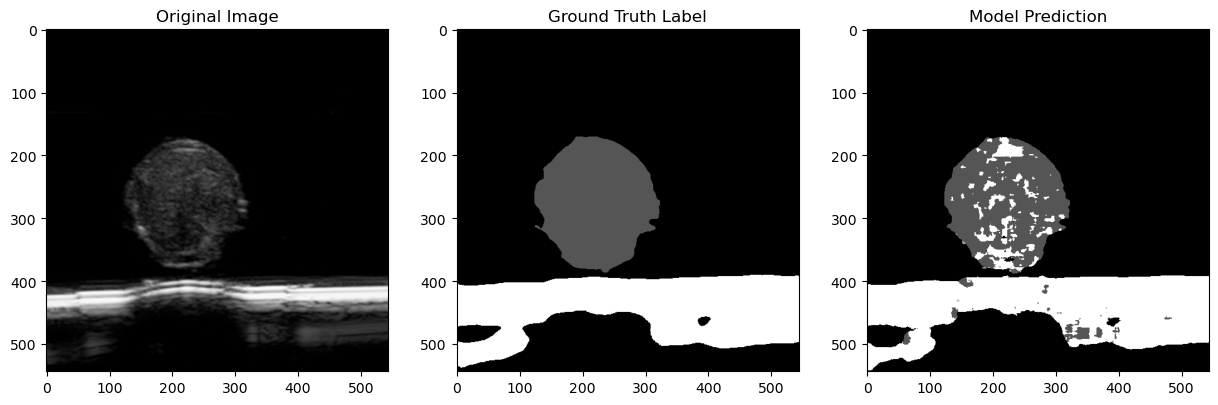

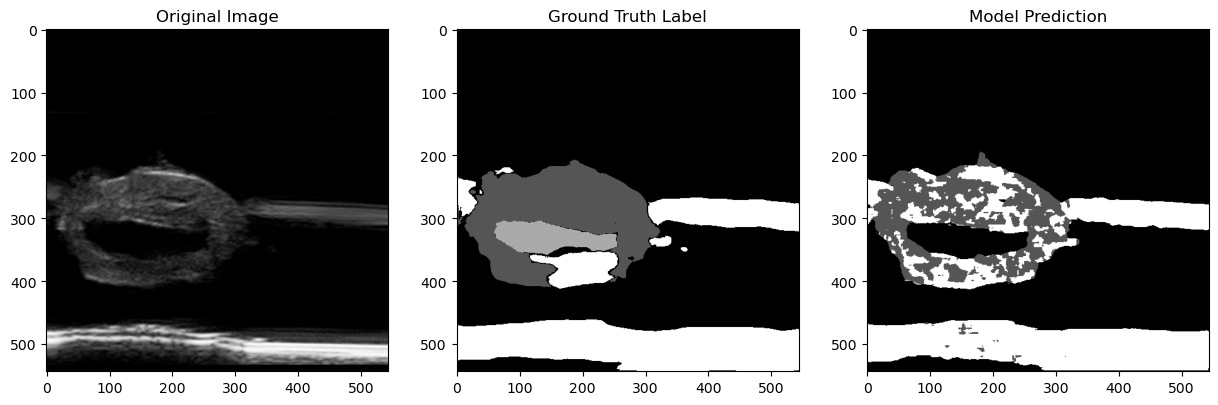

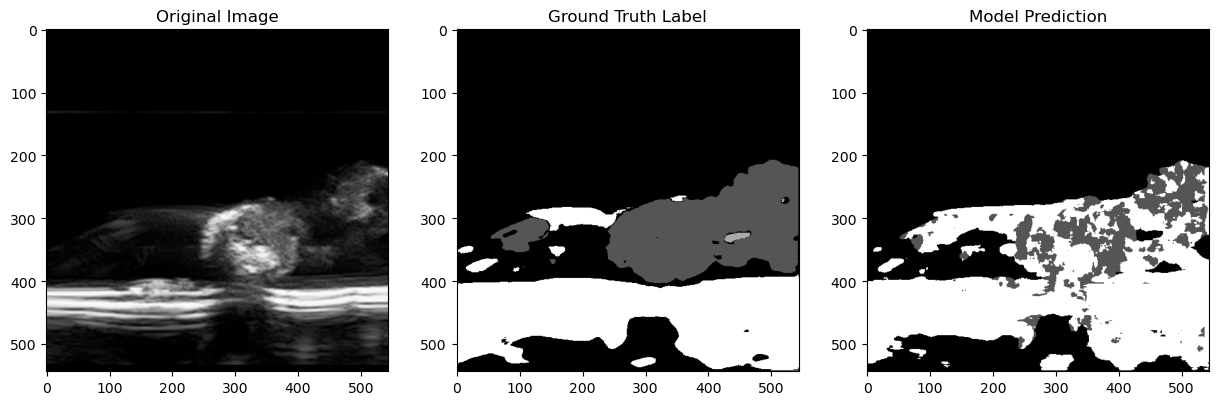

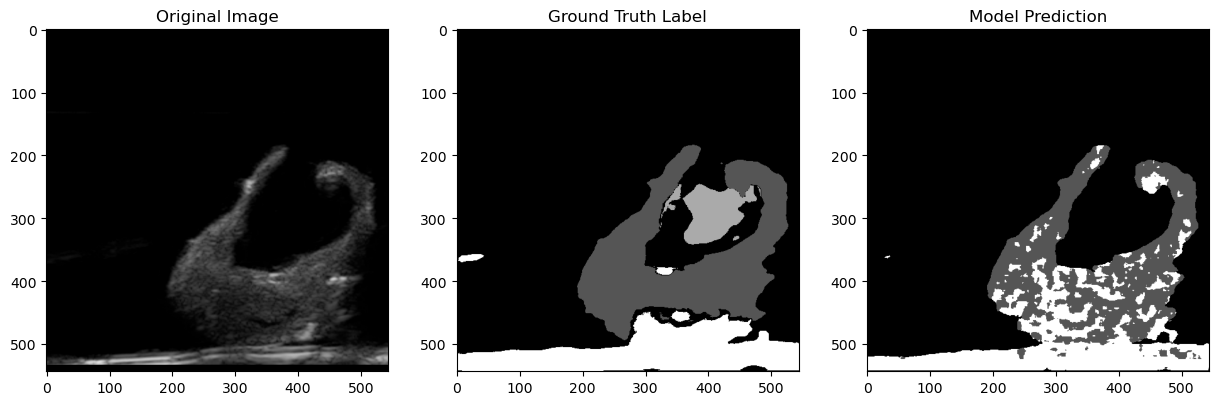

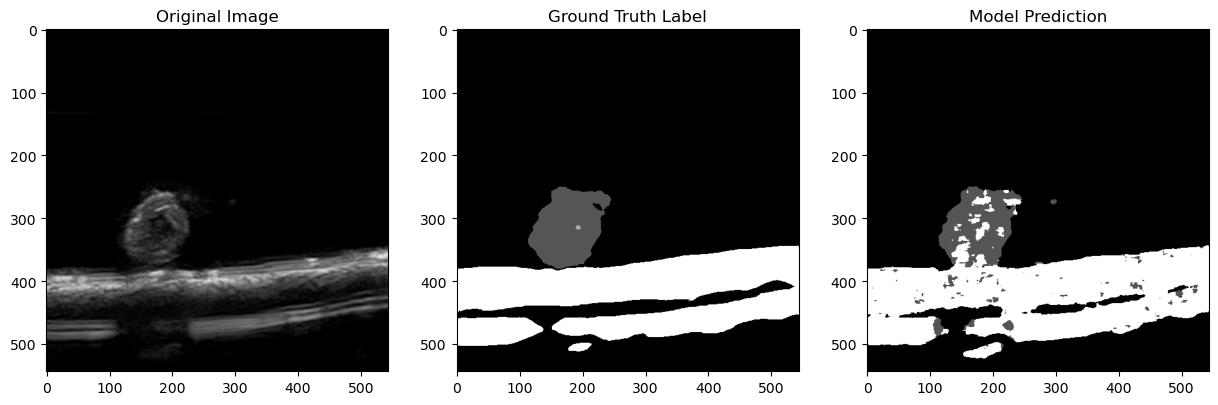

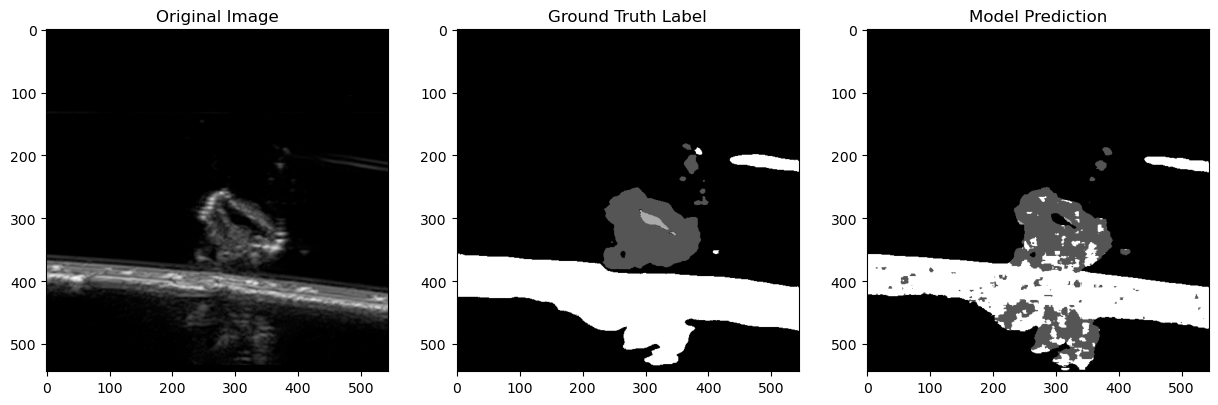

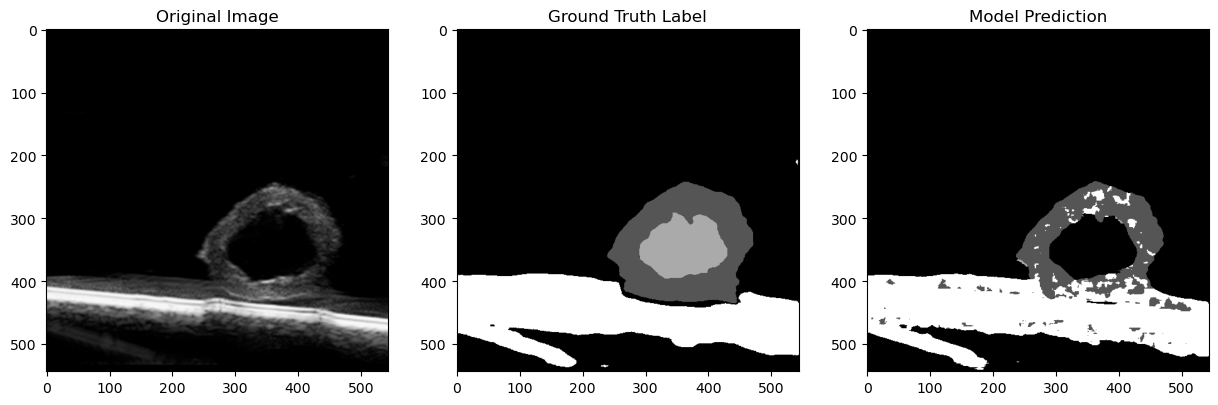

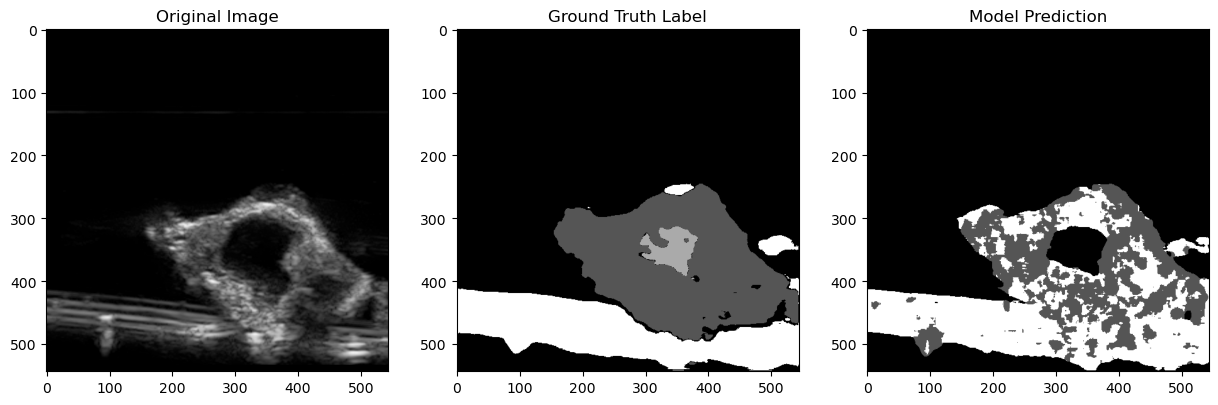

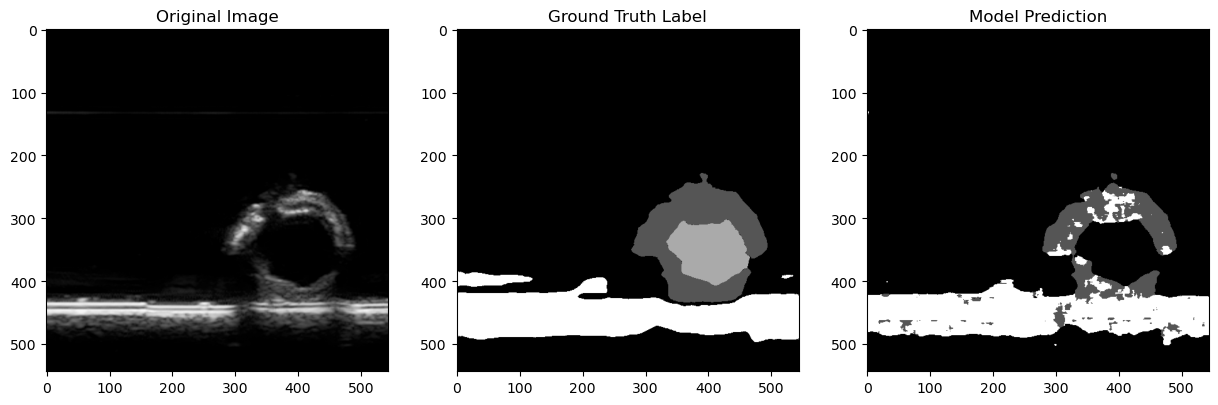

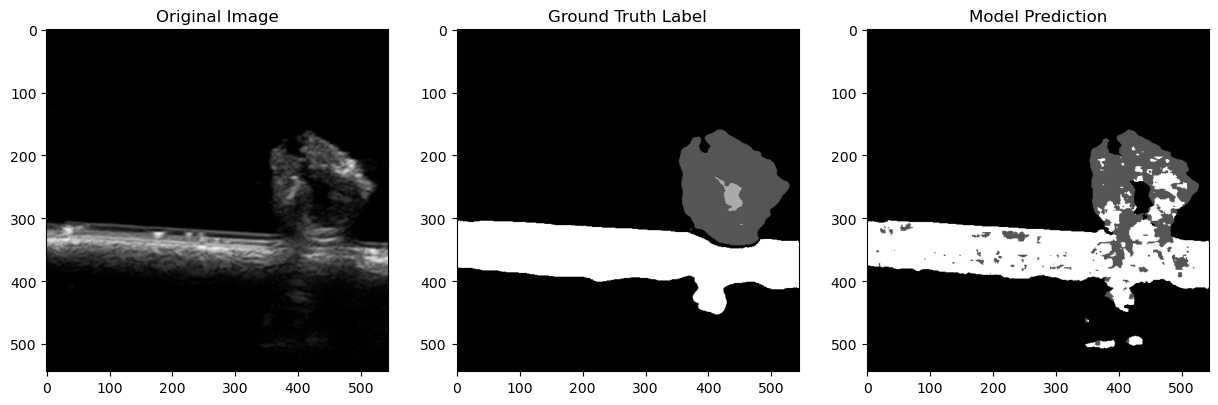

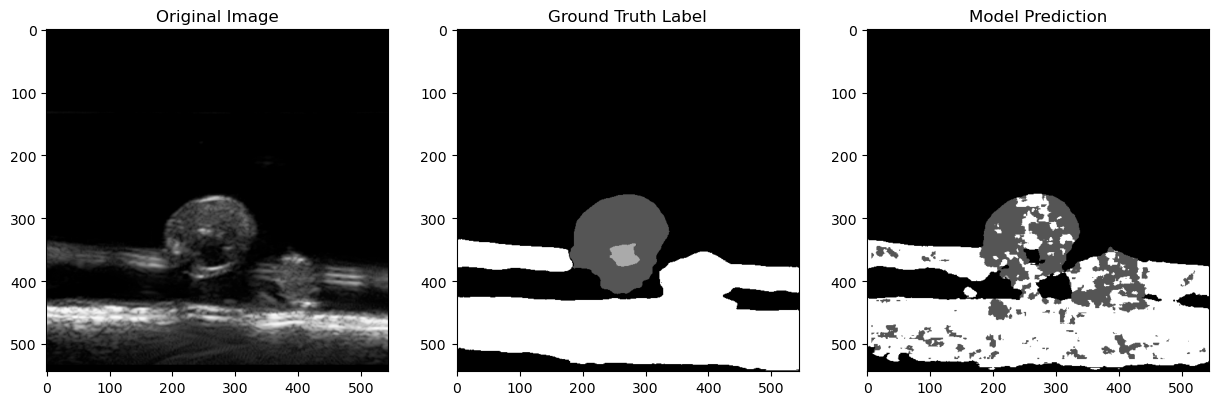

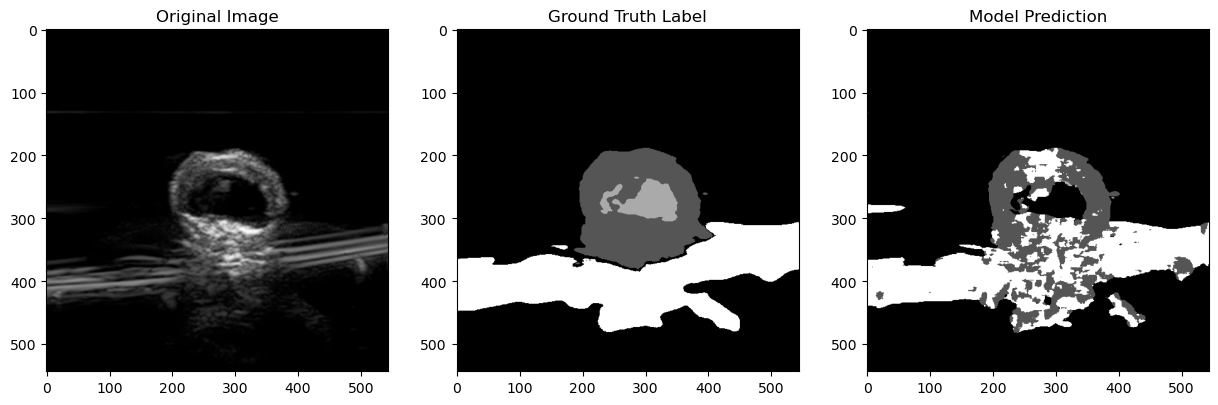

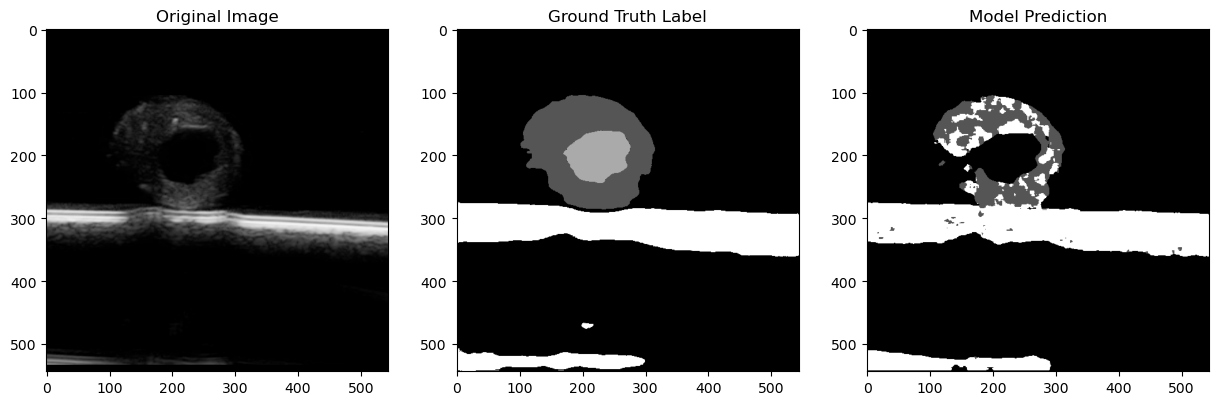

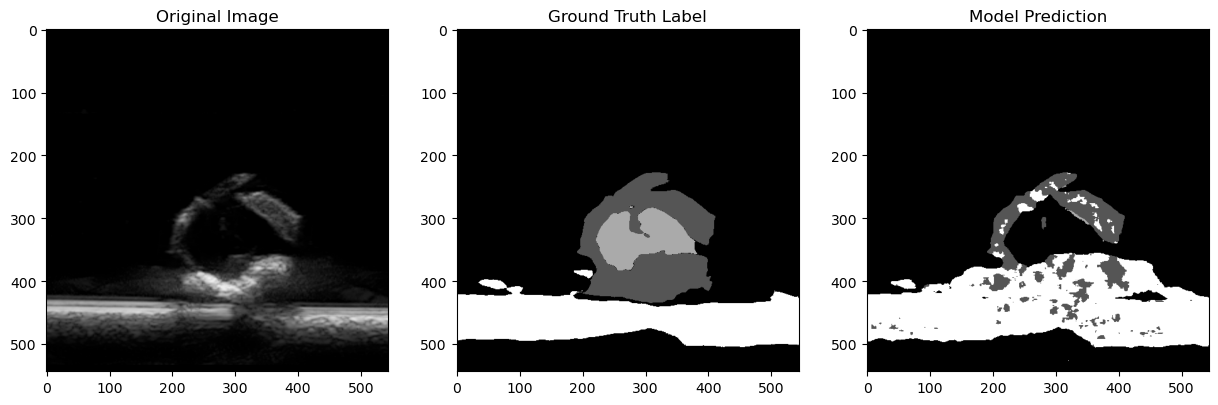

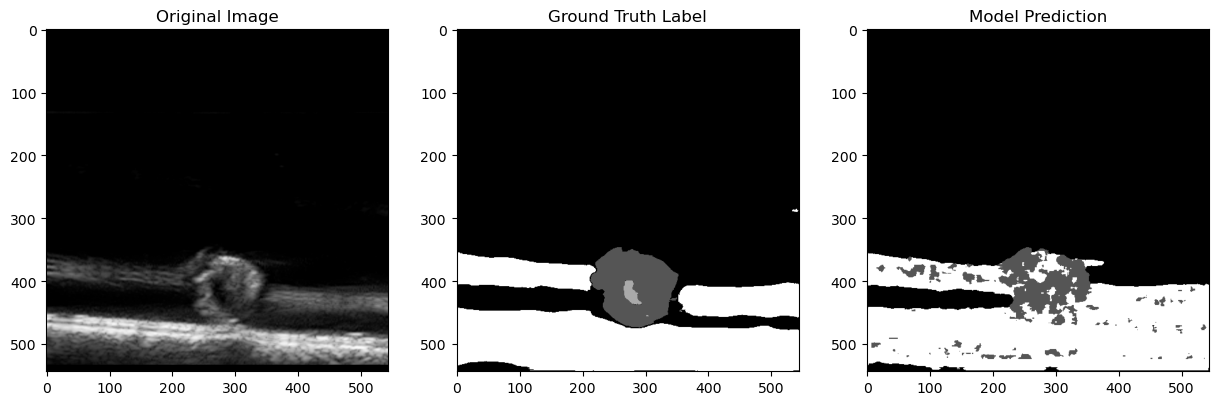

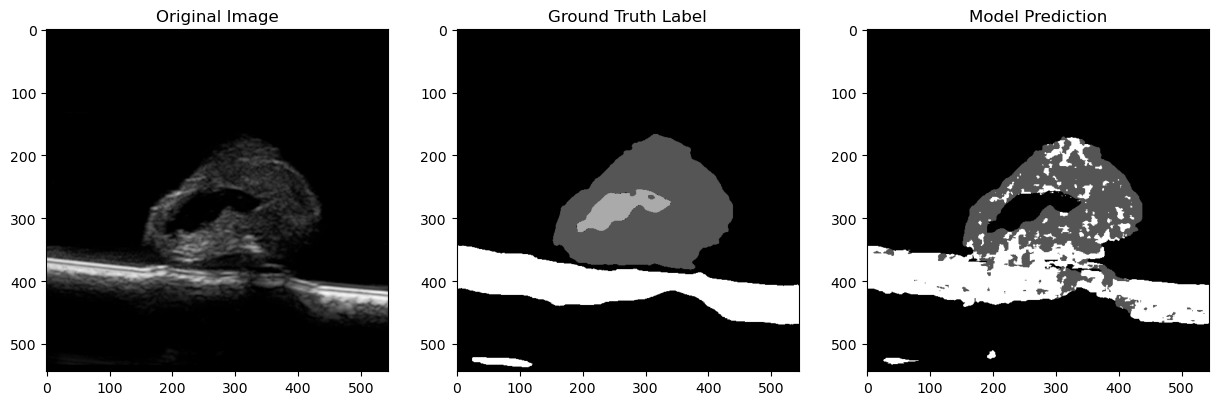

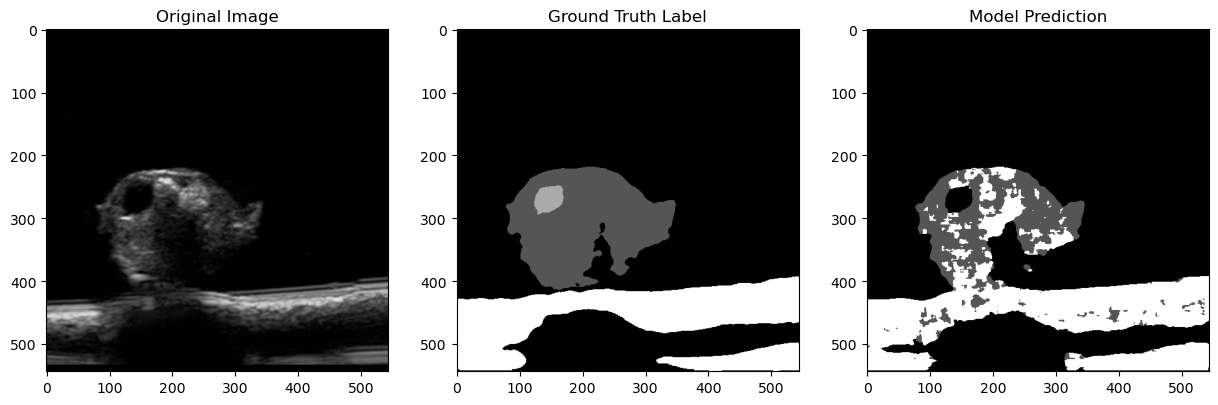

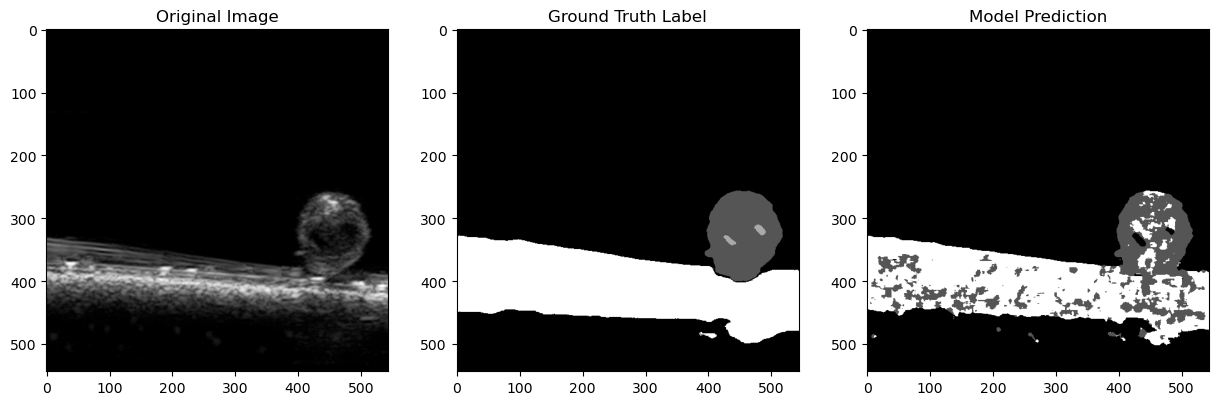

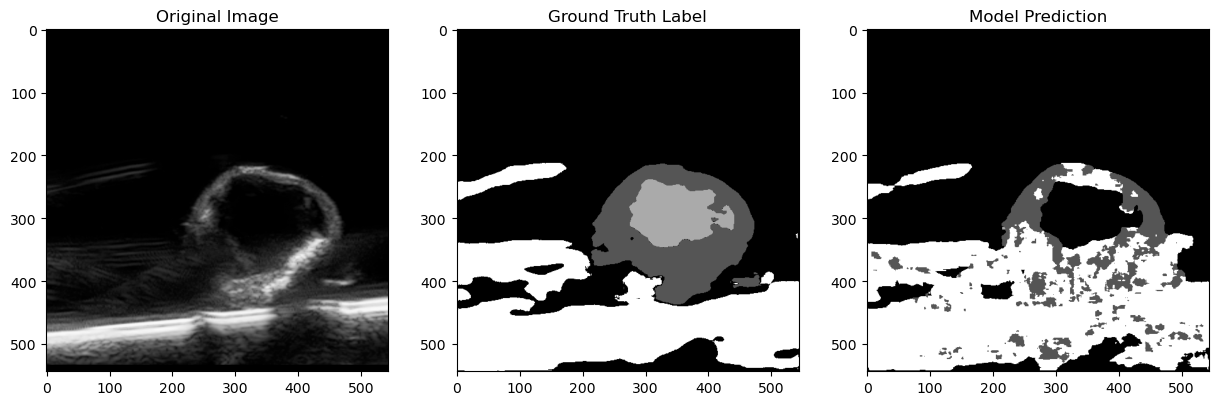

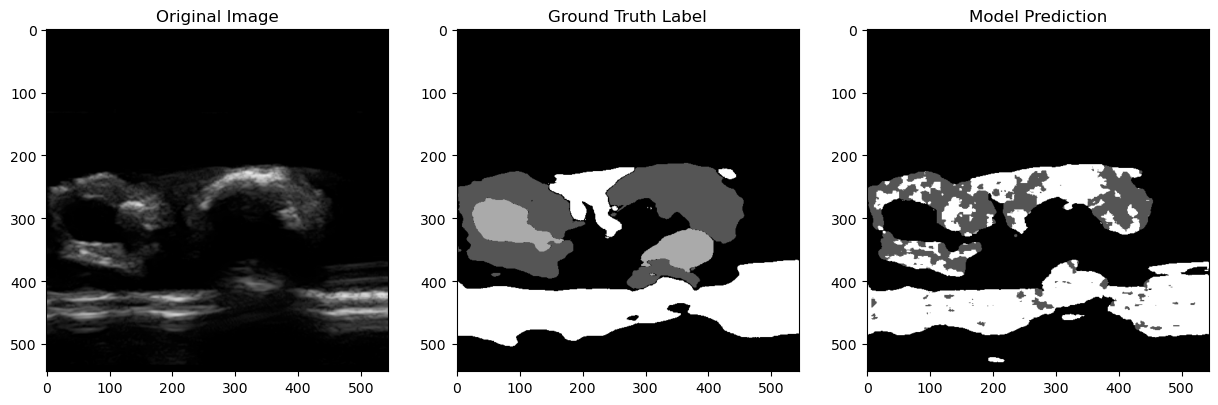

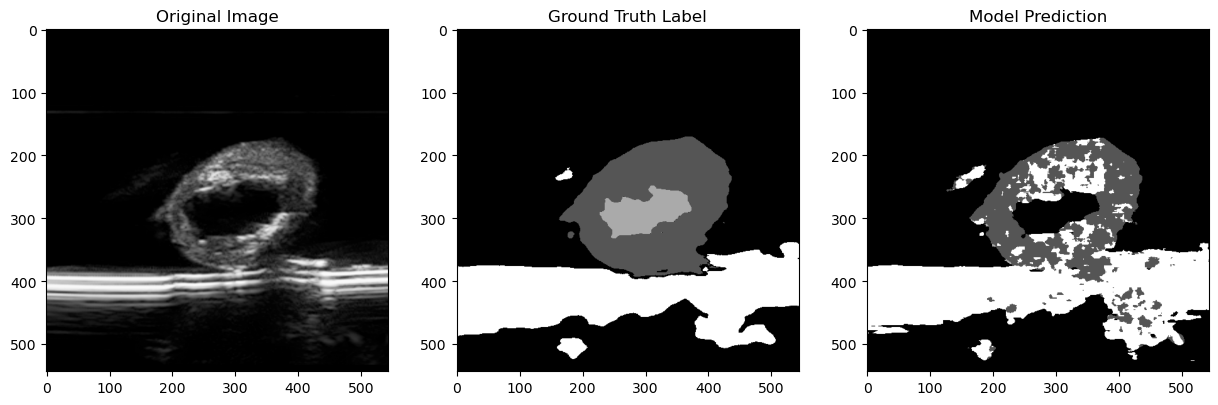

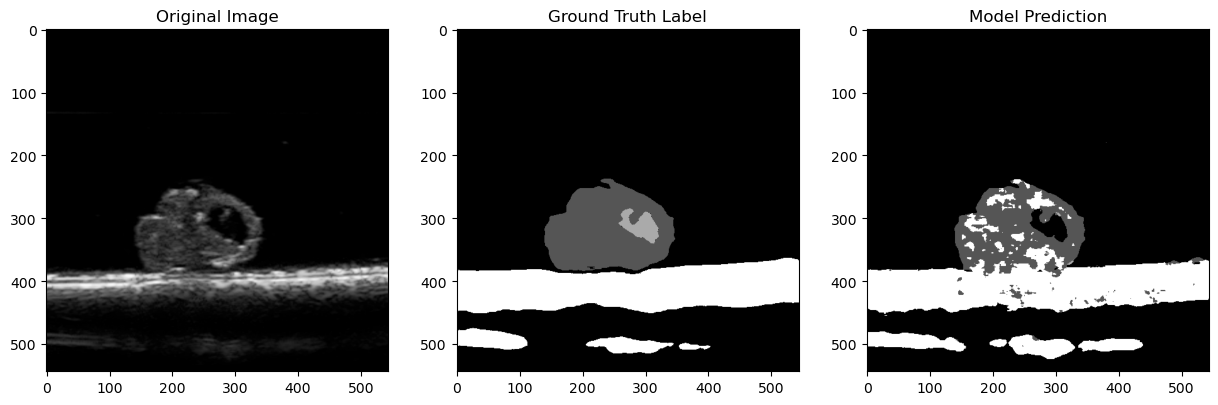

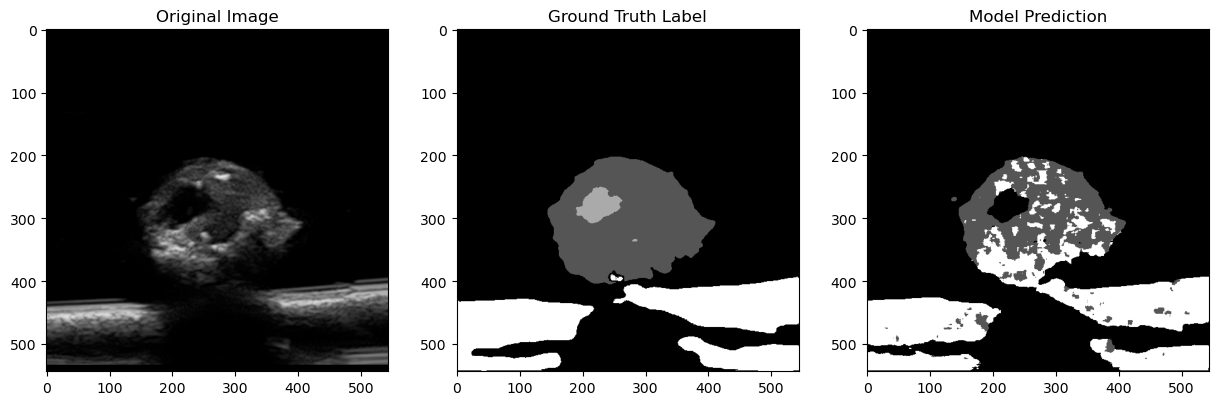

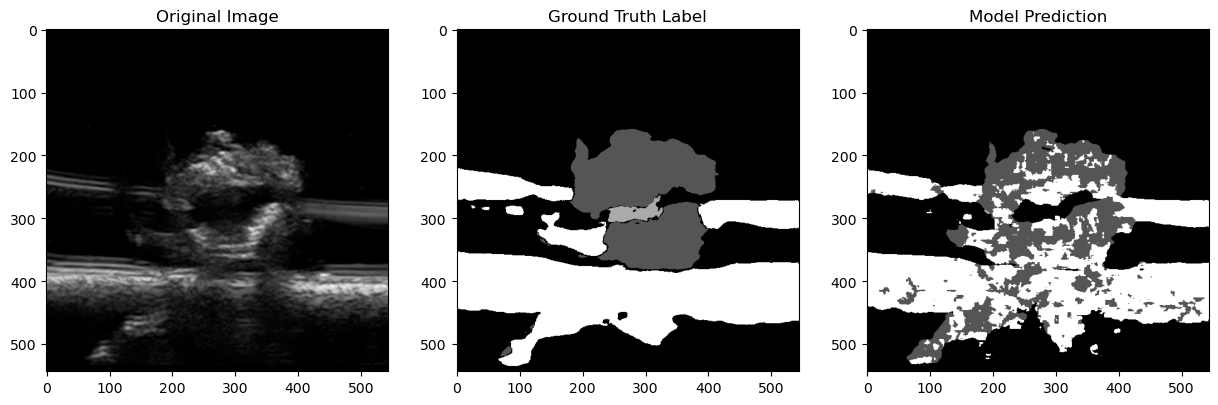

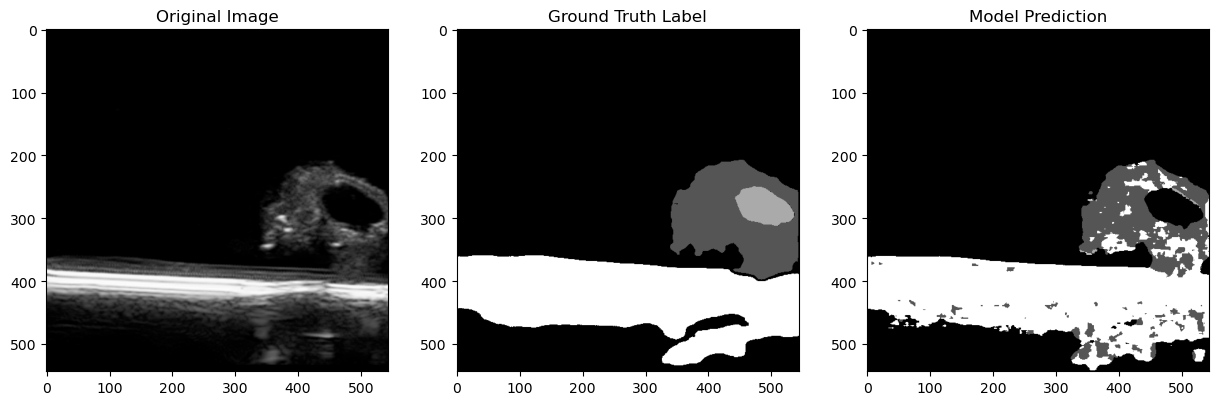

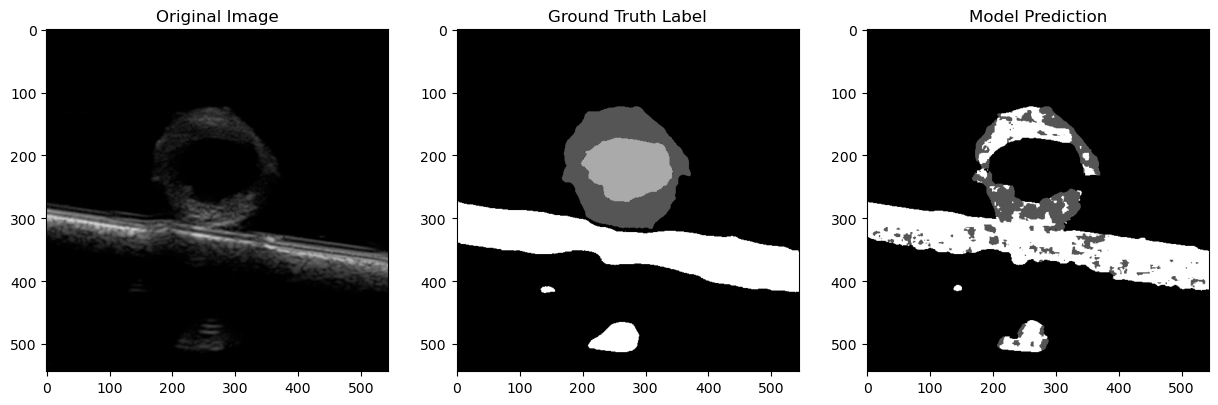

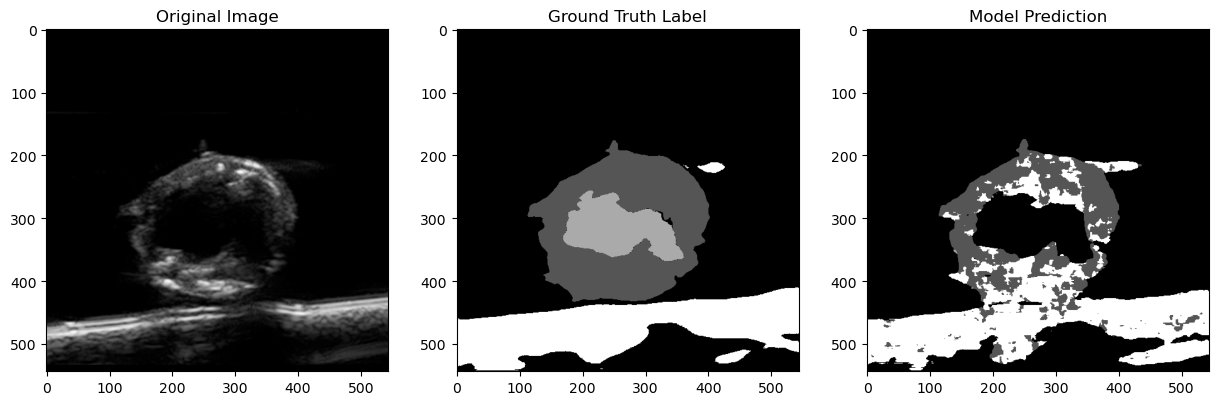

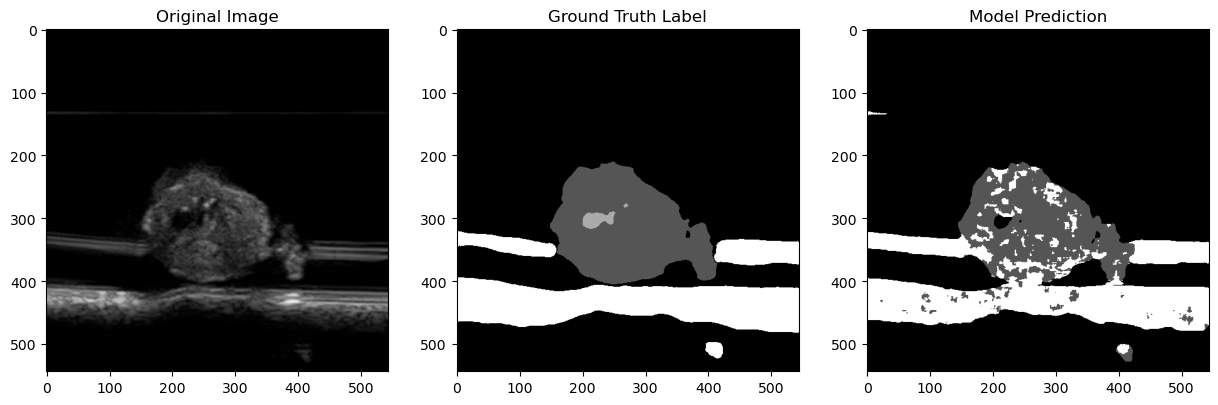

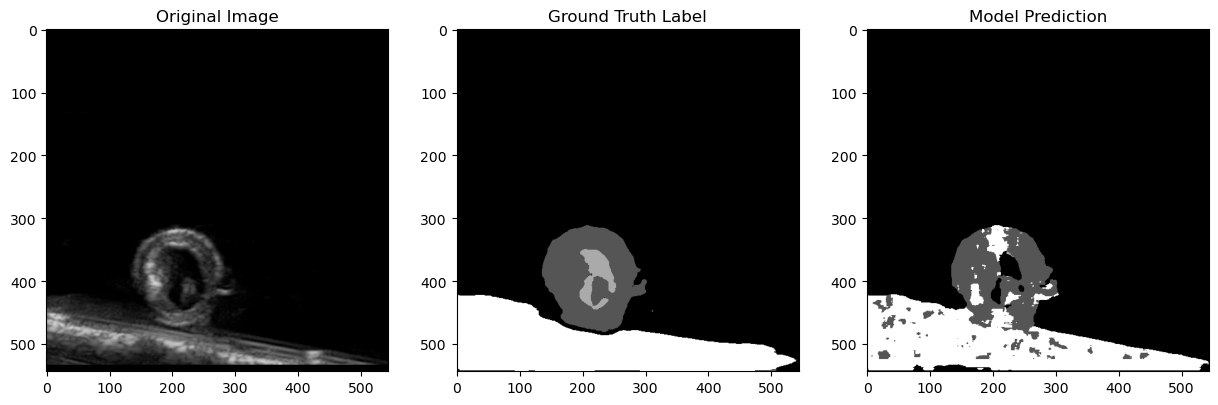

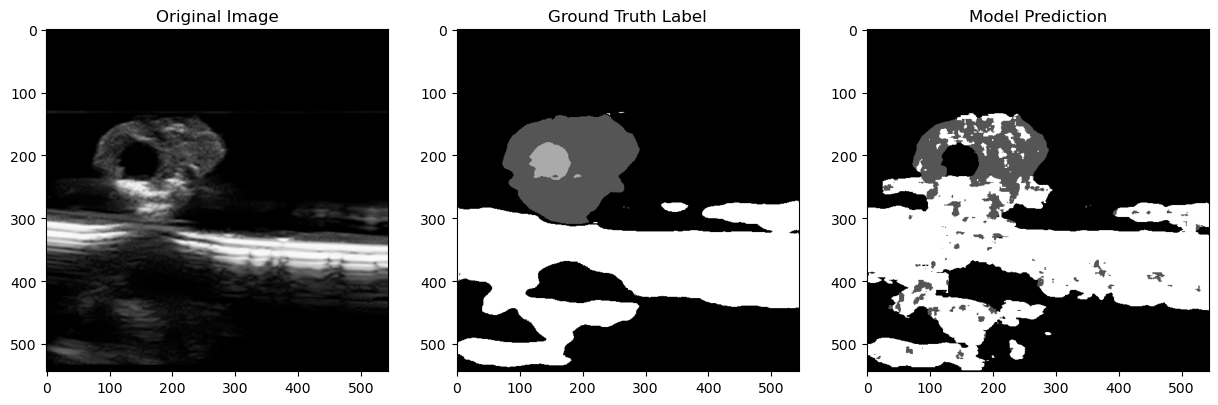

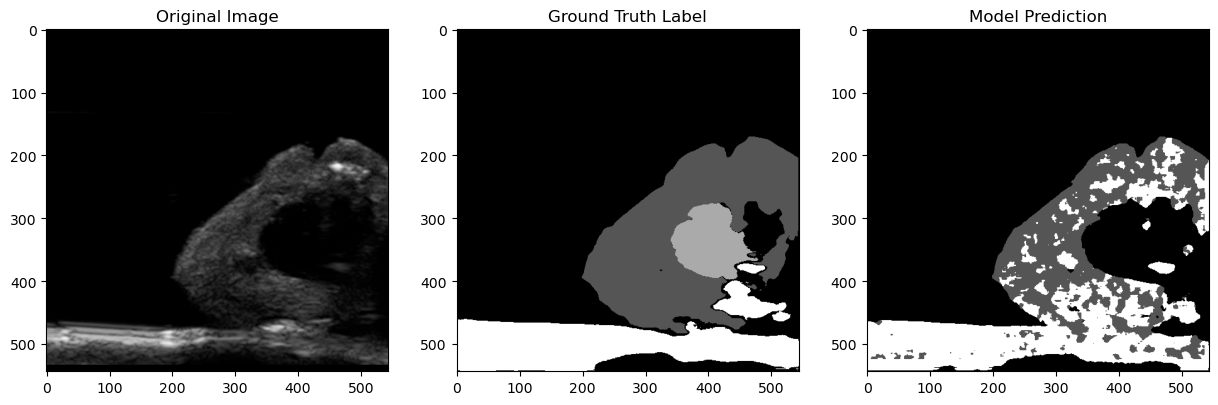

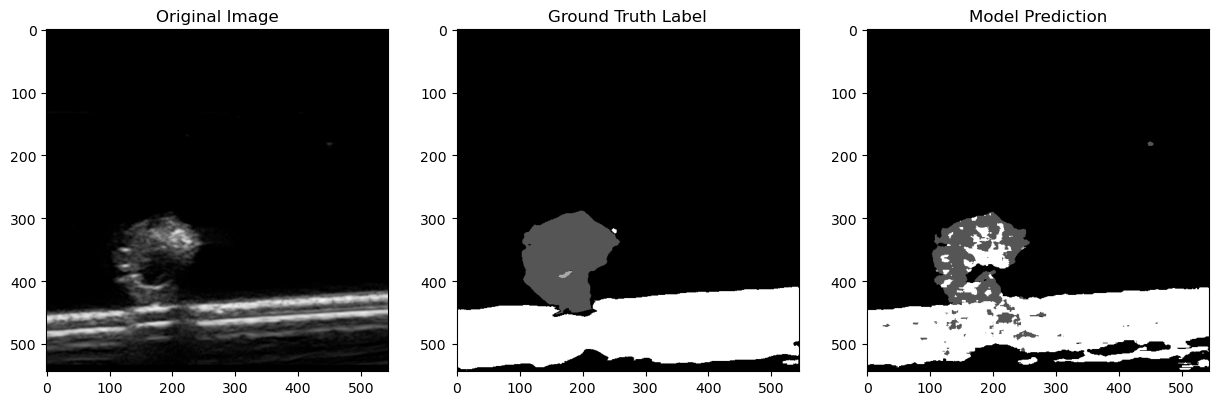

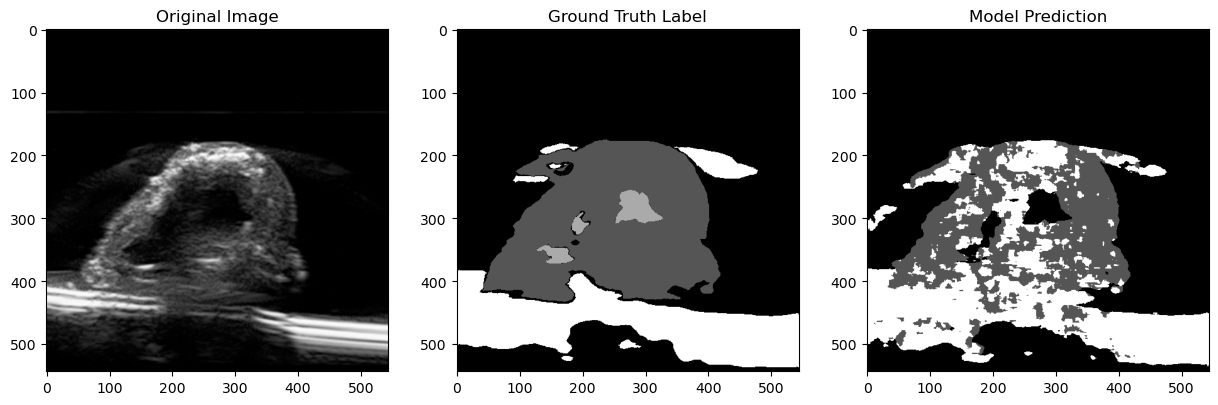

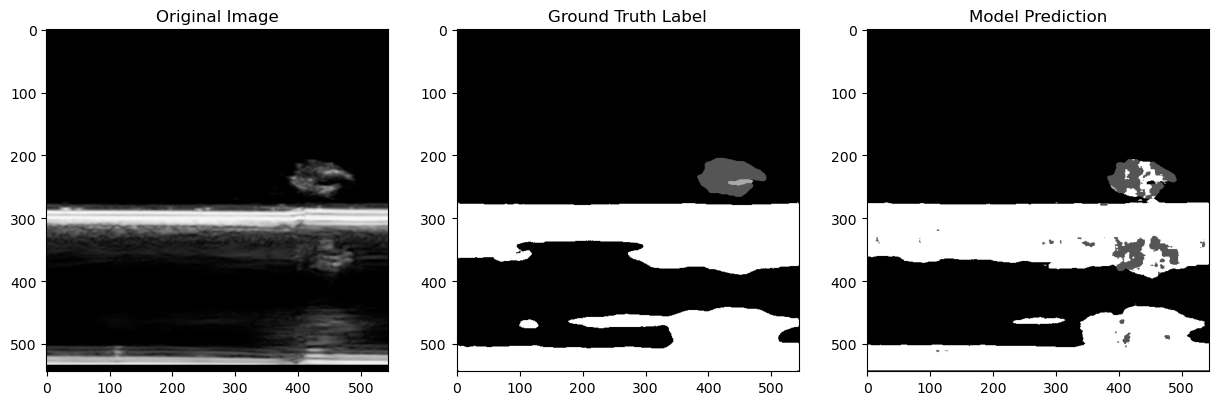

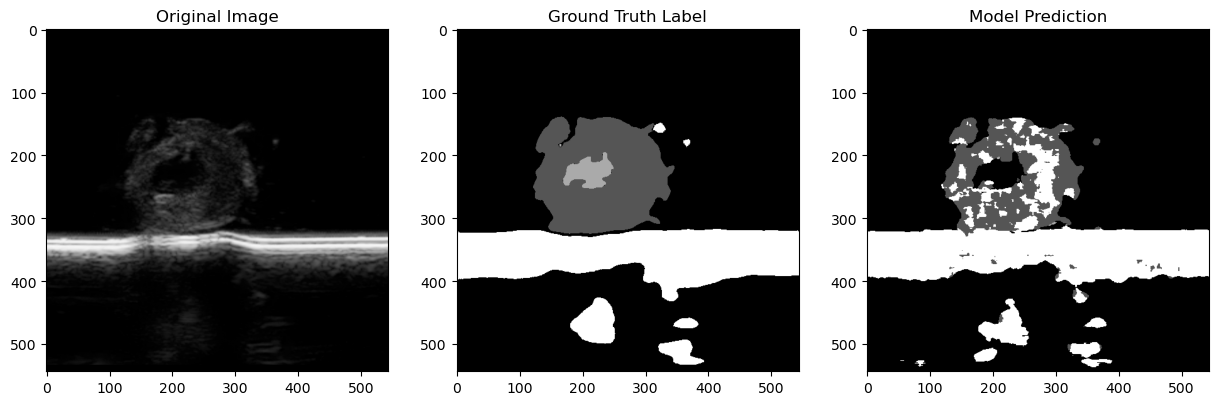

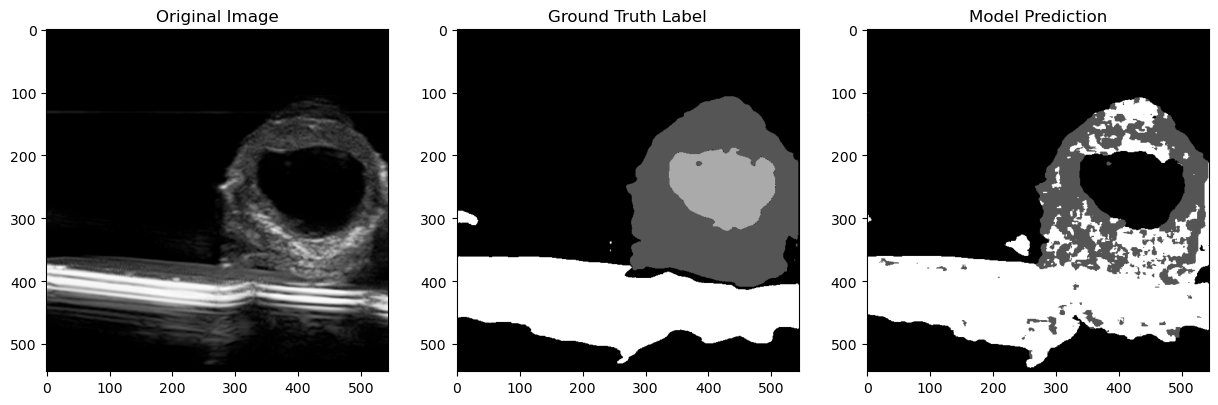

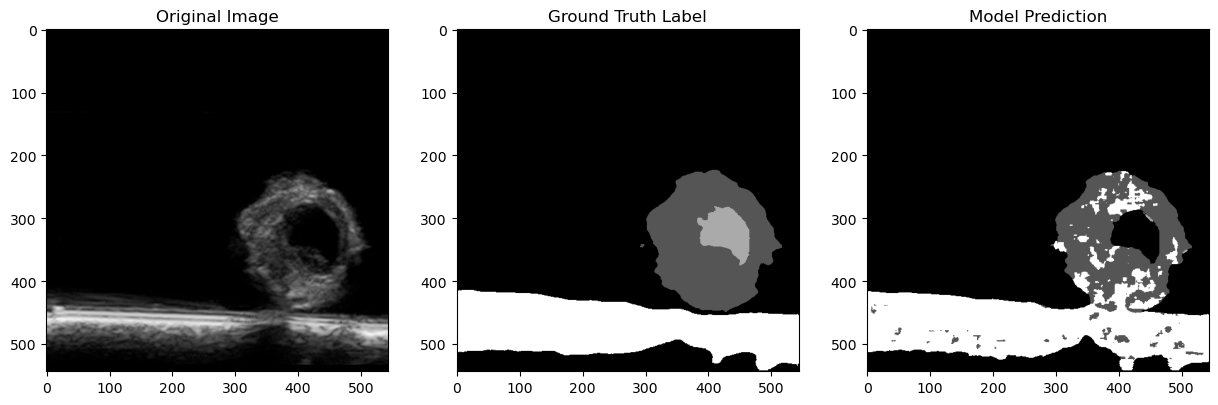

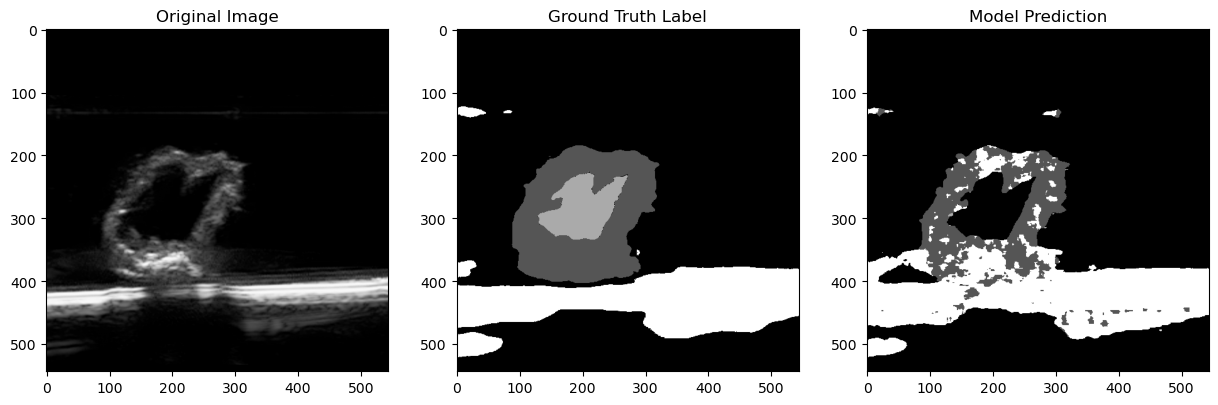

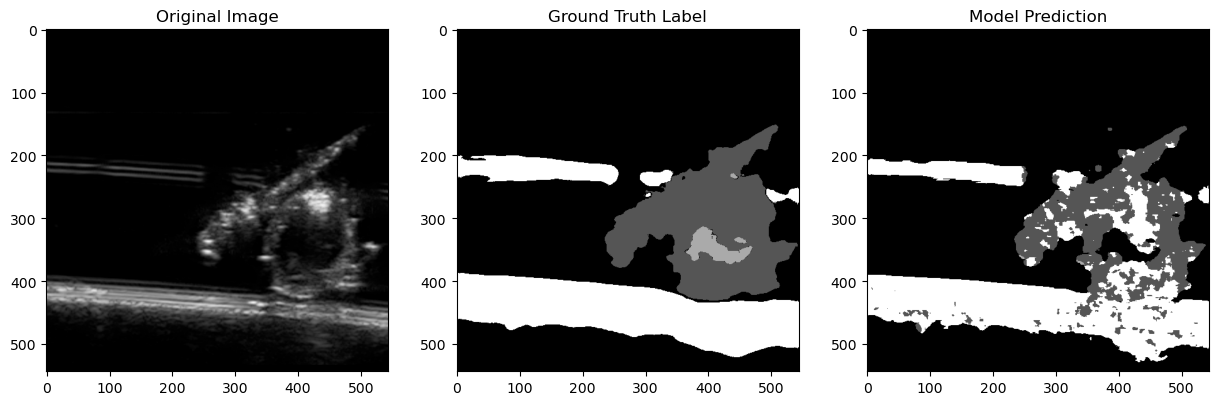

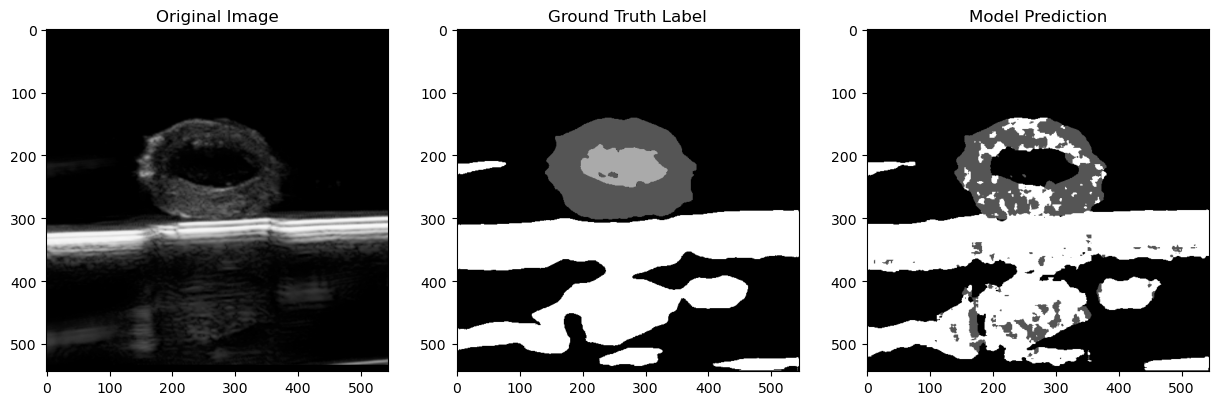

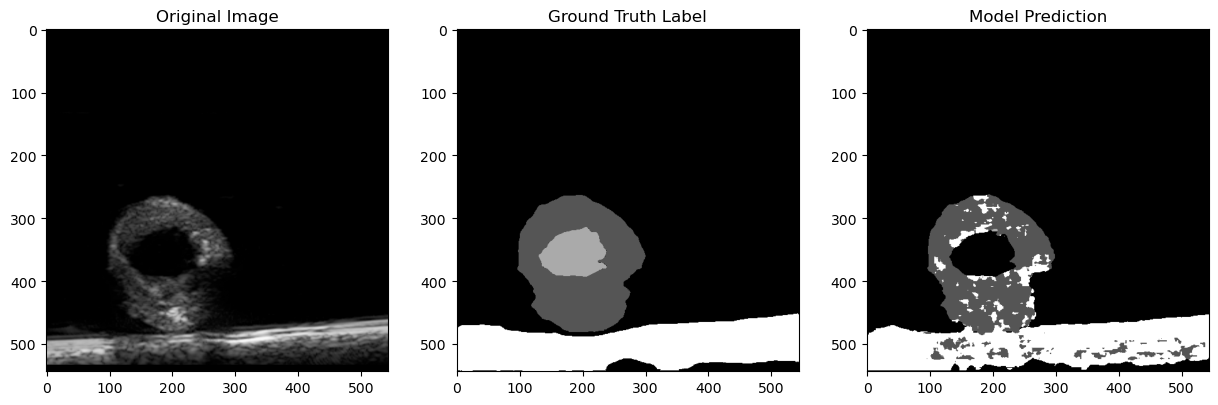

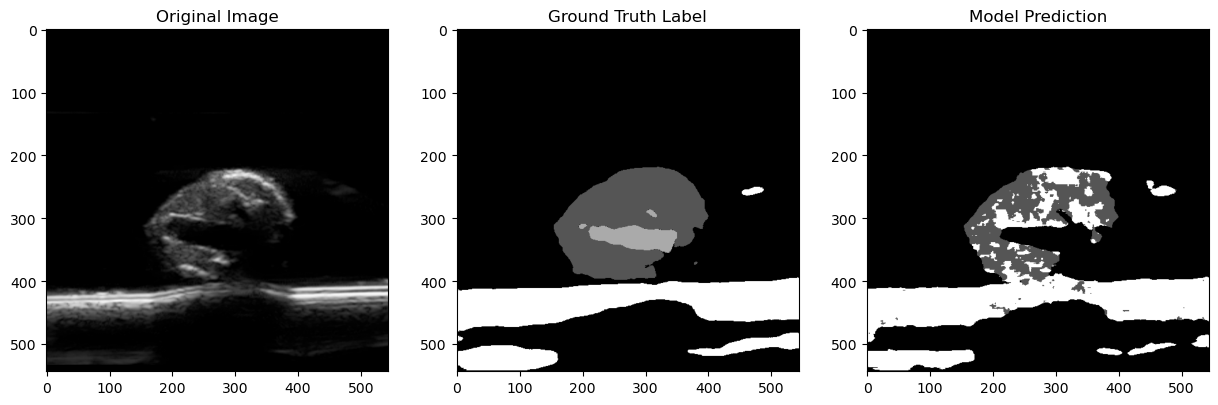

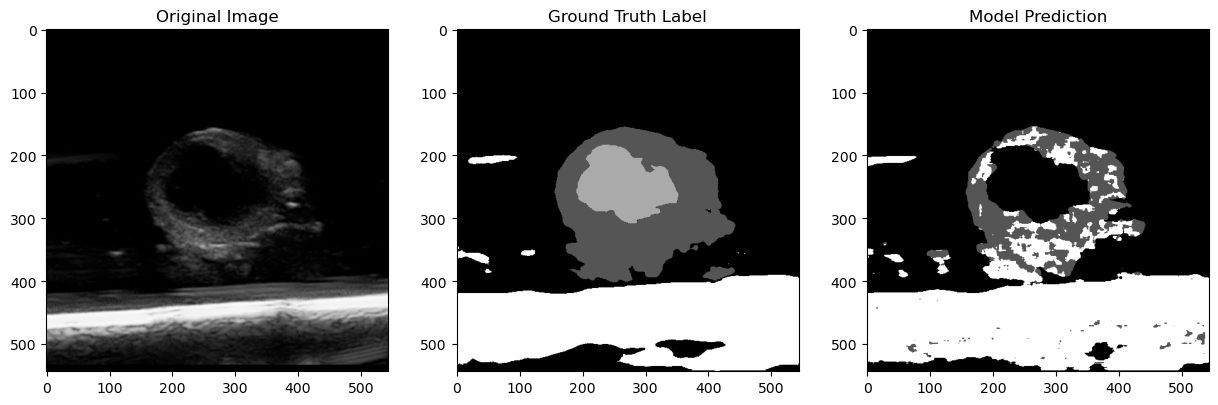

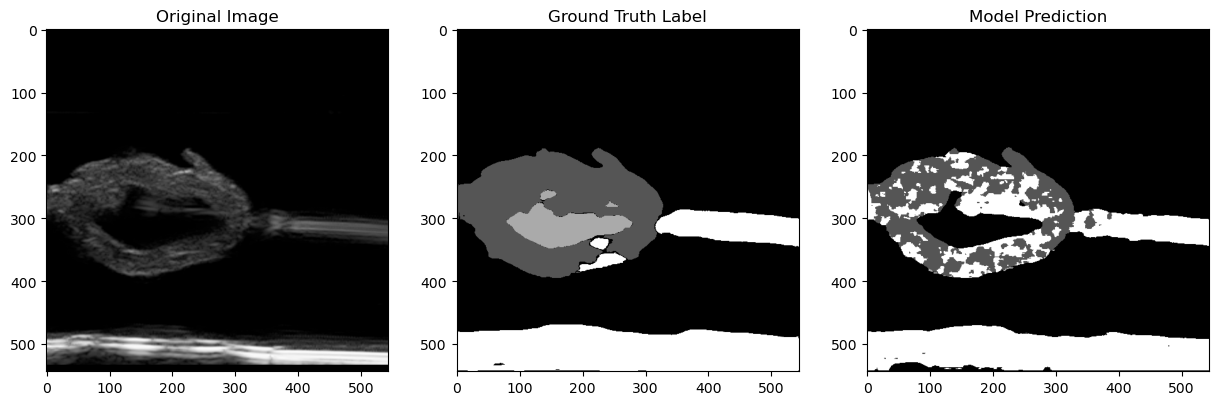

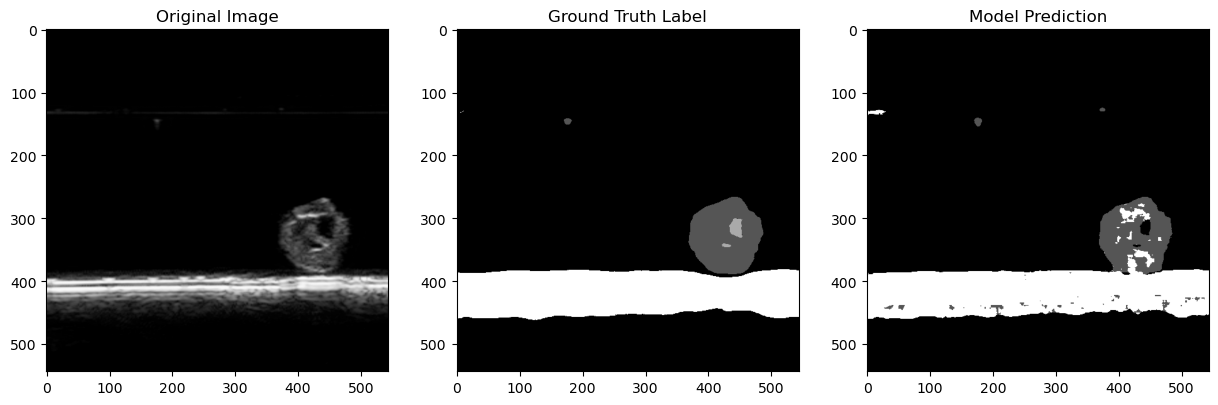

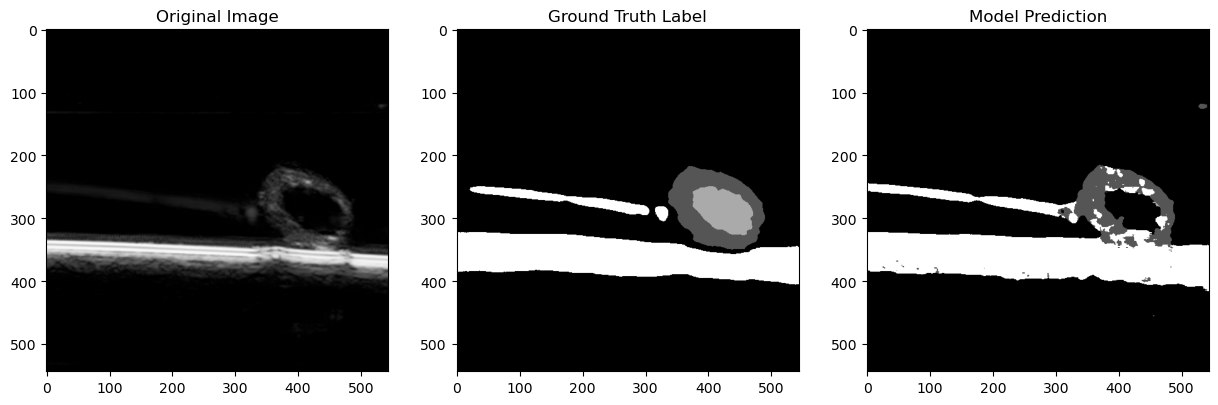

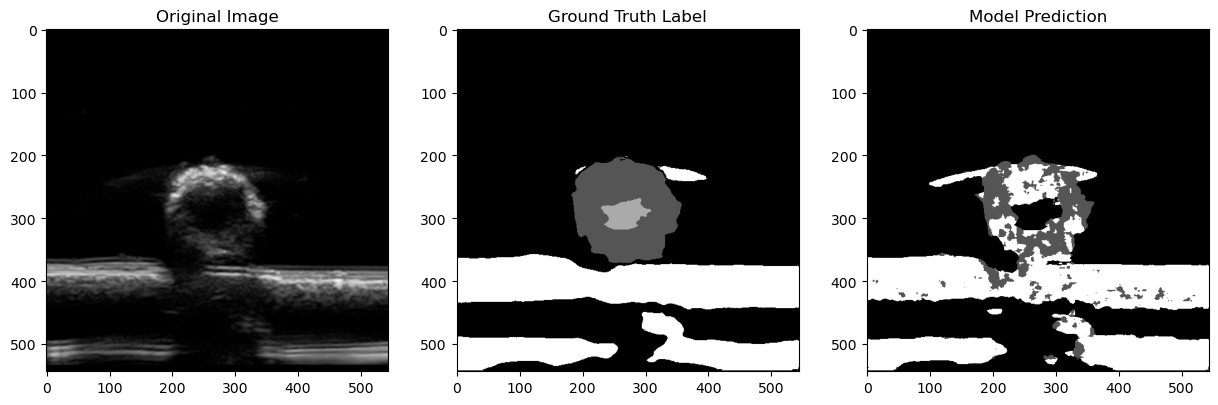

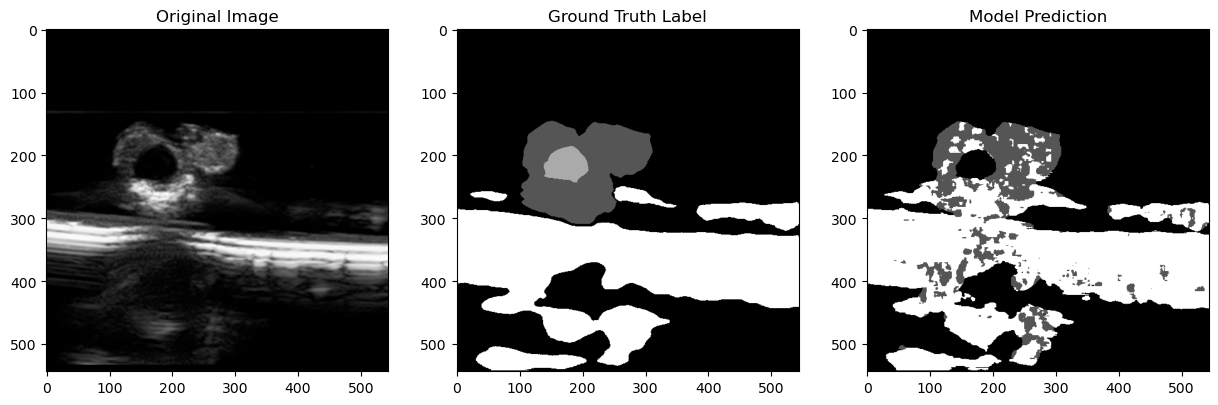

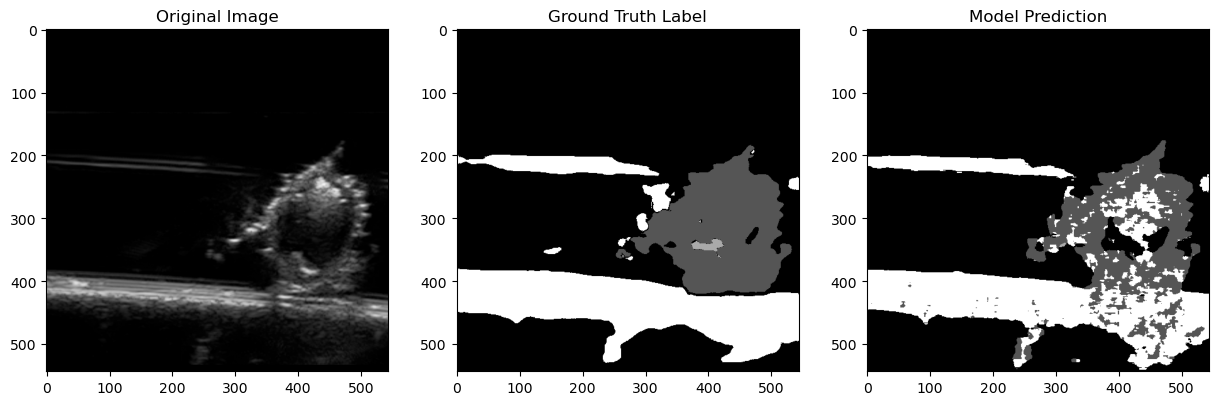

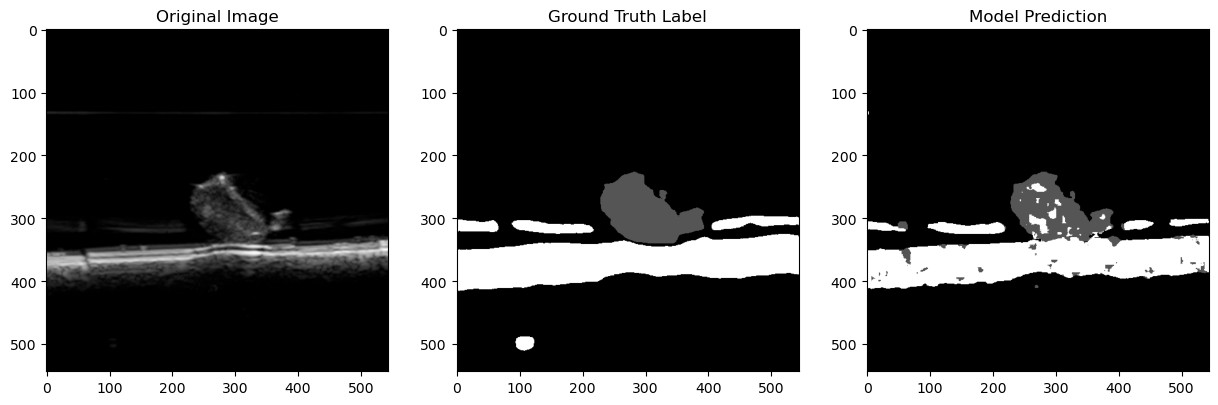

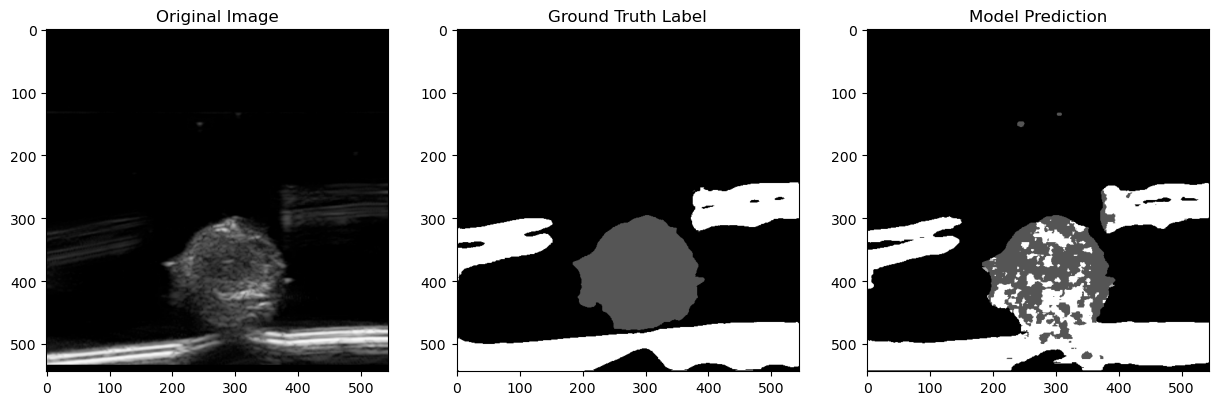

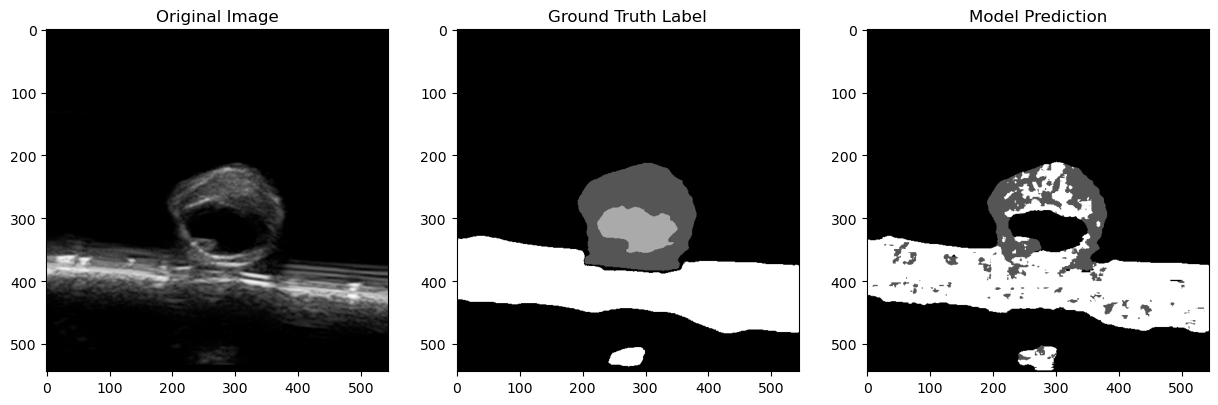

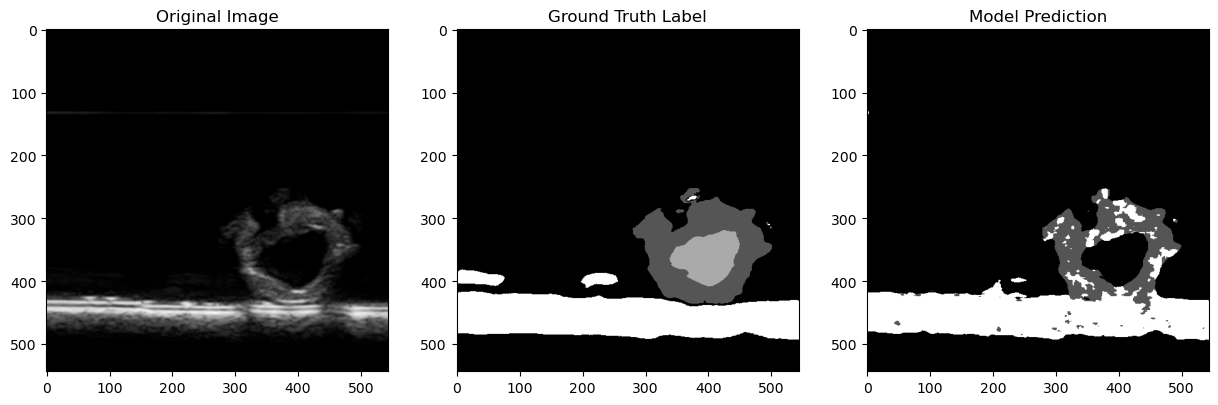

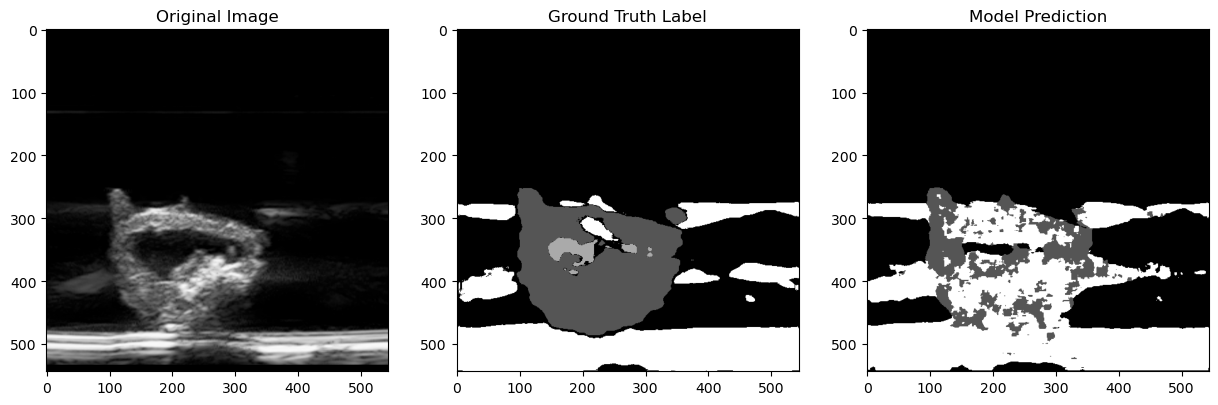

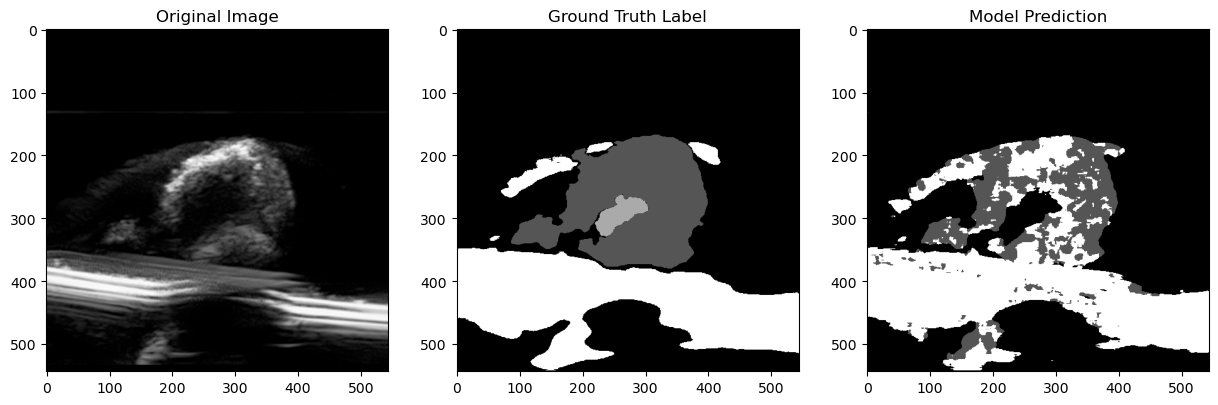

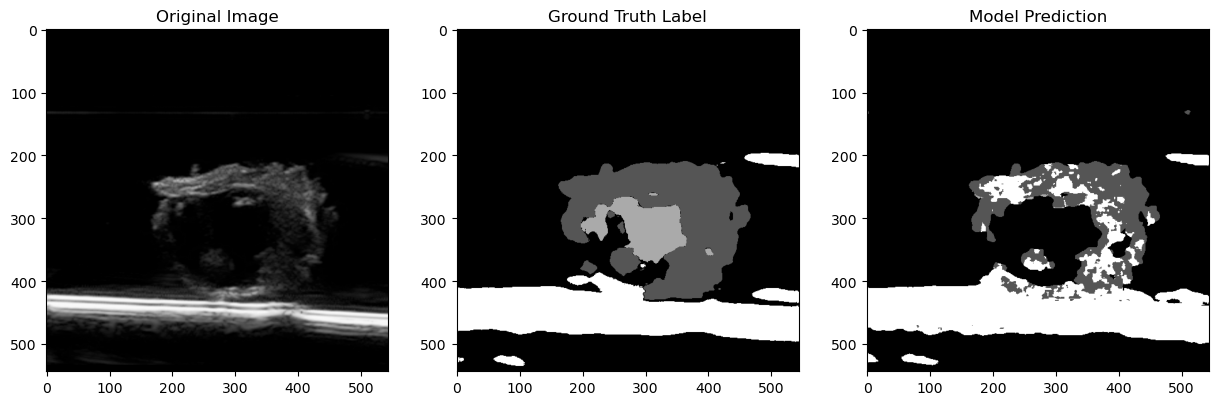

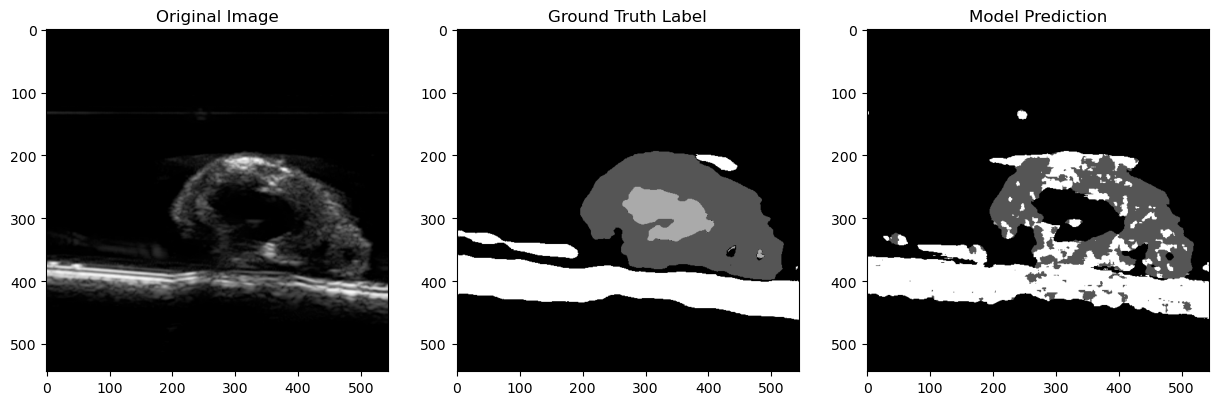

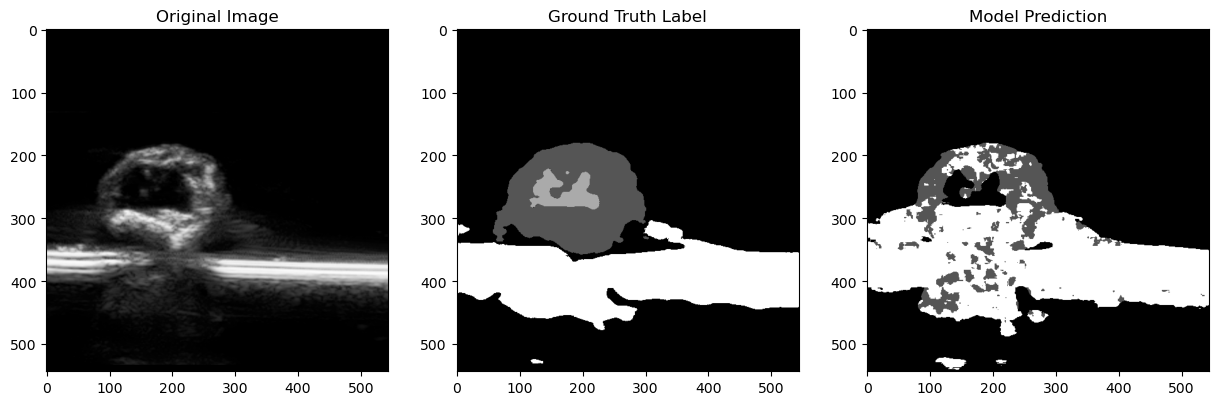

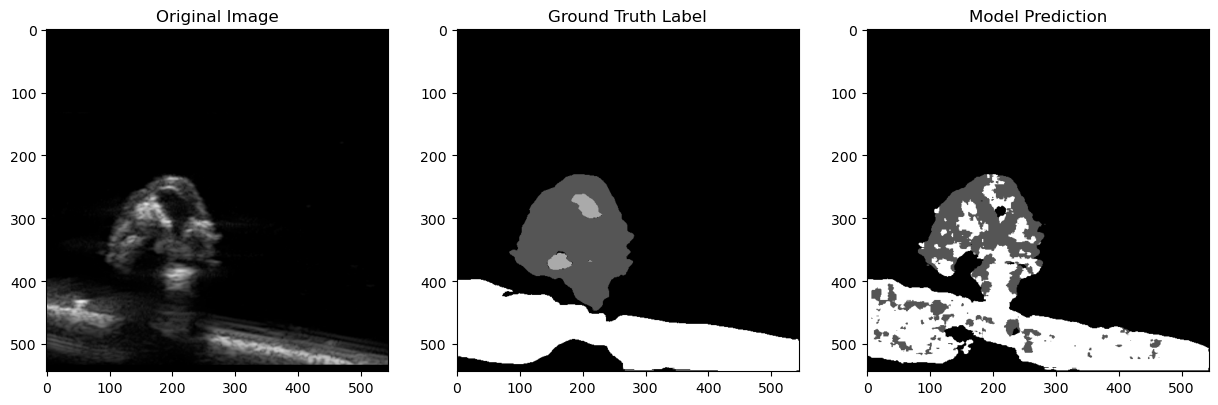

KeyboardInterrupt: 

In [20]:

# Load the trained model
model = tf.keras.models.load_model('unet_model.h5')

# Predict on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to label indices
y_pred_argmax = np.argmax(y_pred, axis=-1)

# Convert the one-hot encoded ground truth labels to label indices
y_true = np.argmax(y_test, axis=-1)

# Display the original images, ground truth labels, and model predictions
for i in range(len(X_test)):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_true[i], cmap='gray')
    plt.title('Ground Truth Label')
    
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_argmax[i], cmap='gray')
    plt.title('Model Prediction')
    
    plt.show()
